In [1]:
from io import StringIO

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as mpl_LinearSegmentedColormap
from matplotlib.colors import SymLogNorm as mpl_SymLogNorm
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
from dishpylib.pyhelpers import get_env_context
from dishpylib.pyhelpers import get_git_revision_hash
from dishpylib.pyhelpers import make_timestamp
from dishpylib.pyhelpers import print_runtime


In [3]:
print_runtime()


context: ci
hostname: 2b3a743c17ba
interpreter: 3.8.15 (default, Oct 12 2022, 19:14:39)  [GCC 7.5.0]
revision: 9e04cf573
timestamp: 2022-11-21T04:12:48Z00:00

IPython==7.16.1
matplotlib==3.5.2
matplotlib==3.5.2
numpy==1.19.5
pandas==1.1.2
seaborn==0.11.2
teeplot==0.1.1


# morph data setup

In [4]:
morph_csv = StringIO('''Stint,Morph,Series
0,a,16005
1,b,16005
2,c,16005
3,b,16005
4,b,16005
5,b,16005
6,b,16005
7,b,16005
8,b,16005
9,b,16005
10,b,16005
11,b,16005
12,b,16005
13,b,16005
14,d,16005
15,e,16005
16,e,16005
17,e,16005
18,e,16005
19,e,16005
20,e,16005
21,e,16005
22,e,16005
23,e,16005
24,e,16005
25,e,16005
26,b,16005
27,e,16005
28,b,16005
29,e,16005
30,e,16005
31,e,16005
32,e,16005
33,e,16005
34,e,16005
35,e,16005
36,e,16005
37,e,16005
38,e,16005
39,f,16005
40,e,16005
41,e,16005
42,e,16005
43,e,16005
44,e,16005
45,g,16005
46,g,16005
47,g,16005
48,g,16005
49,g,16005
50,g,16005
51,g,16005
52,g,16005
53,e,16005
54,g,16005
55,g,16005
56,g,16005
57,g,16005
58,g,16005
59,h,16005
60,g,16005
61,e,16005
62,g,16005
63,g,16005
64,e,16005
65,e,16005
66,g,16005
67,g,16005
68,e,16005
69,g,16005
70,e,16005
71,e,16005
72,e,16005
73,g,16005
74,i,16005
75,i,16005
76,g,16005
77,i,16005
78,e,16005
79,g,16005
80,e,16005
81,e,16005
82,e,16005
83,e,16005
84,e,16005
85,e,16005
86,e,16005
87,e,16005
88,e,16005
89,g,16005
90,g,16005
91,e,16005
92,i,16005
93,e,16005
94,e,16005
95,b,16005
96,b,16005
97,h,16005
98,e,16005
99,e,16005
100,j,16005
''')

df_morph = pd.read_csv(morph_csv)


In [5]:
color_key = {
    'a' : 'tab:blue',
    'b' : 'tab:orange',
    'c' : 'tab:green',
    'd' : 'tab:red',
    'e' : 'tab:purple',
    'f' : 'tab:brown',
    'g' : 'tab:pink',
    'h' : 'tab:gray',
    'i' : 'tab:olive',
    'j' : 'tab:cyan',
}


In [6]:
morph_key = {
    row['Stint'] : row['Morph']
    for idx, row in df_morph.iterrows()
}


# treatment info setup

In [7]:
background_key = {
    "immediatepredecessor-simuls-dosecorrected-withbioticbackground-withmut"
        : "Prefatory",
    "immediatepredecessor-simuls-dosecorrected-withfuturebioticbackground-withmut"
        : "Contemporary",
    "immediatepredecessor-simuls-nobioticbackground-withmut"
        : "Without",
    "lowestroot-immediatepredecessor-battles"
        : "Without",
    "immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withbioticbackground-withmut"
        : "Prefatory\n(no diversity maint.)",
    "immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withfuturebioticbackground-withmut"
        : "Contemporary\n(no diversity maint.)",
    "immediatepredecessor-battles-dosecorrected-withbioticbackground-withmut"
        : "Prefatory",
    "immediatepredecessor-battles-dosecorrected-withfuturebioticbackground-withmut"
        : "Contemporary",
}


In [8]:
def subject_key(setup: str) -> str:
    if 'simul' in setup or 'competition' in setup:
        return 'Specimen'
    elif 'battle' in setup:
        return 'Population'
    else:
        assert False


In [9]:
dfs = []
for setup in (
    "immediatepredecessor-simuls-dosecorrected-withbioticbackground-withmut",
    "immediatepredecessor-simuls-dosecorrected-withfuturebioticbackground-withmut",
    "immediatepredecessor-simuls-nobioticbackground-withmut",
    "lowestroot-immediatepredecessor-battles",
    "immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withbioticbackground-withmut",
    "immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withfuturebioticbackground-withmut",
    "immediatepredecessor-battles-dosecorrected-withbioticbackground-withmut",
    "immediatepredecessor-battles-dosecorrected-withfuturebioticbackground-withmut",
):    
    print(setup)
    df = pd.read_csv(
        f"https://prq49.s3.us-east-2.amazonaws.com/endeavor%3D16/{setup}/stage%3D2%2Bwhat%3Dcollated/a%3Dconcat%2Bhow%3Dmanual%2Bext%3D.csv"    
    )
    df["setup"] = setup
    if "Fitness Differential Focal" not in df:
        df["Fitness Differential Focal"] = df["Fitness Differential"]
    if "Focal Prevalence" not in df:
        df["Focal Prevalence"] = df["Prevalence"]
    if "Focal Abundance" not in df:
        df["Focal Abundance"] = df["Abundance"]

    df['Positive Fitness Differential Focal'] = df['Fitness Differential Focal'] > 0

    dfs.append(df)


immediatepredecessor-simuls-dosecorrected-withbioticbackground-withmut
immediatepredecessor-simuls-dosecorrected-withfuturebioticbackground-withmut
immediatepredecessor-simuls-nobioticbackground-withmut
lowestroot-immediatepredecessor-battles
immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withbioticbackground-withmut
immediatepredecessor-simuls-dosecorrected-nodiversitymaintenance-withfuturebioticbackground-withmut
immediatepredecessor-battles-dosecorrected-withbioticbackground-withmut
immediatepredecessor-battles-dosecorrected-withfuturebioticbackground-withmut


In [10]:
df = pd.concat(dfs, ignore_index=True)
df['Biotic Background'] = df['setup'].apply(lambda setup: background_key[setup])
df['Assay Subject'] = df['setup'].apply(lambda setup: subject_key(setup))
df['Assay Subject'] = df['setup'].apply(lambda setup: subject_key(setup))


In [11]:
digest = '{:x}'.format(pd.util.hash_pandas_object( df ).sum())
digest


'5149f6b3e6cb134e'

# competition prevalence barplot, boxplot

findfont: Font family ['Fira Mono'] not found. Falling back to DejaVu Sans.


teeplots/hue=biotic-background+viz=facet-barplot+x=competition-stint+y=focal-prevalence+ext=.pdf
teeplots/hue=biotic-background+viz=facet-barplot+x=competition-stint+y=focal-prevalence+ext=.png
teeplots/hue=biotic-background+stint=1-50+viz=facet-barplot+x=competition-stint+y=focal-prevalence+ext=.pdf
teeplots/hue=biotic-background+stint=1-50+viz=facet-barplot+x=competition-stint+y=focal-prevalence+ext=.png
teeplots/hue=biotic-background+stint=51-100+viz=facet-barplot+x=competition-stint+y=focal-prevalence+ext=.pdf
teeplots/hue=biotic-background+stint=51-100+viz=facet-barplot+x=competition-stint+y=focal-prevalence+ext=.png


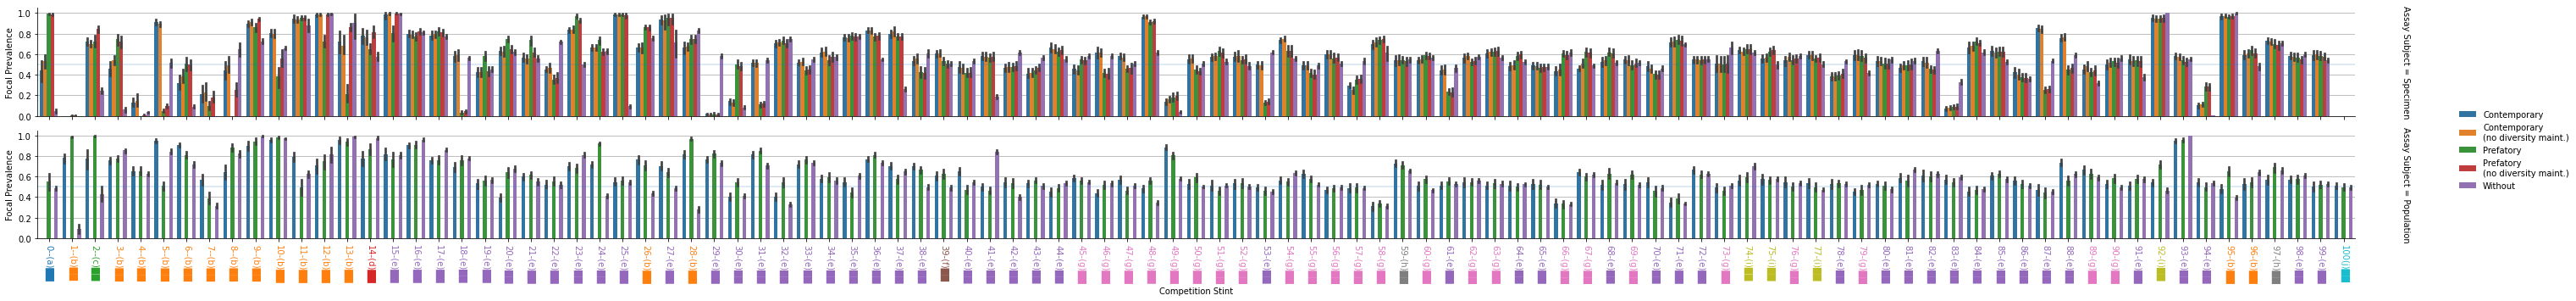

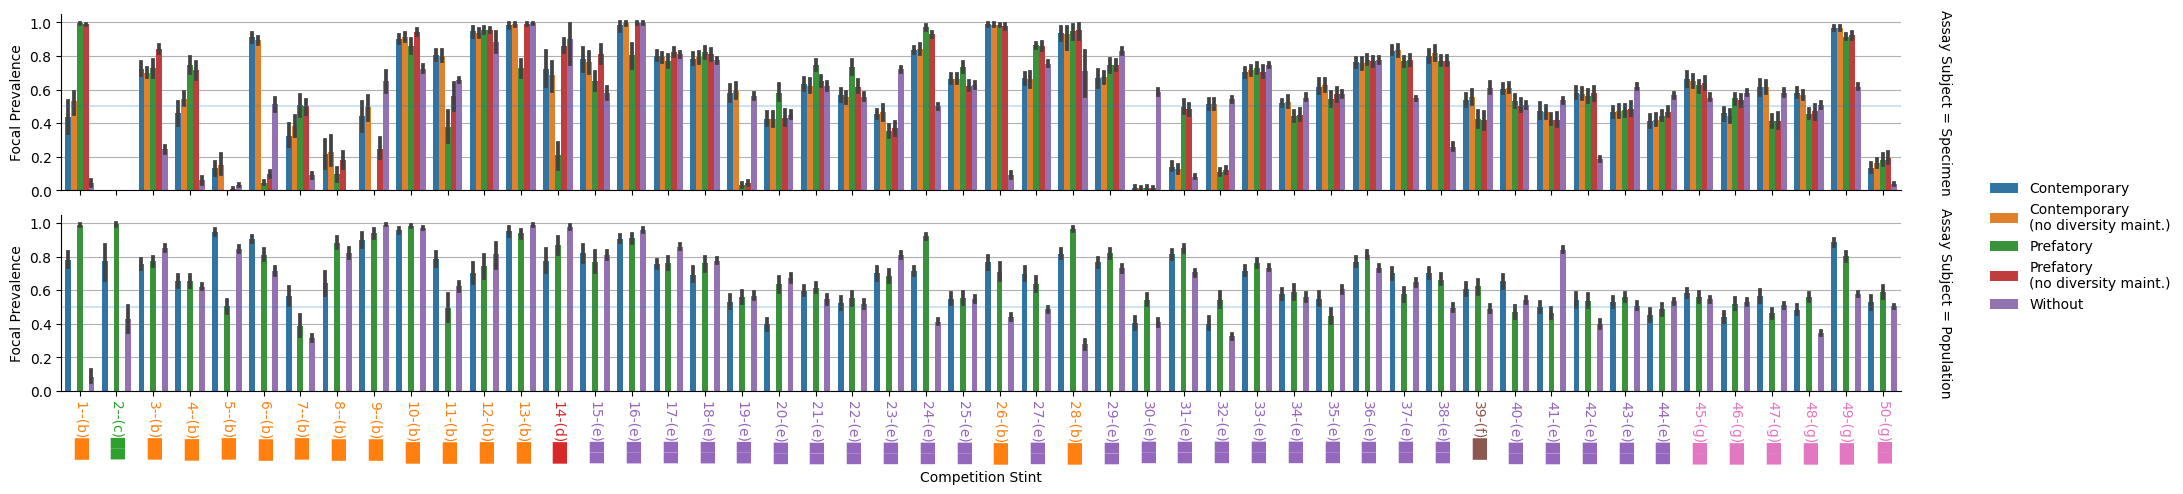

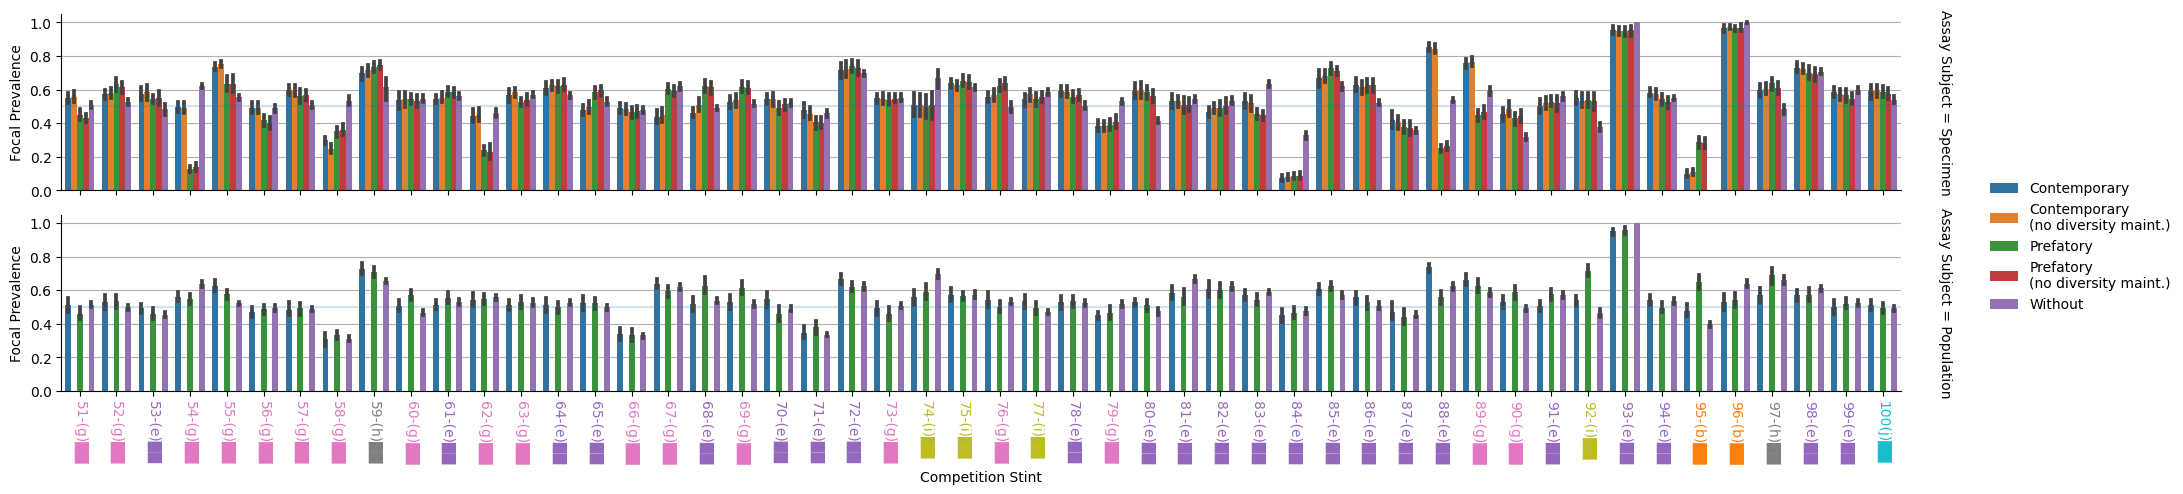

In [12]:
def barplot(*args, **kwargs):
    ax = sns.barplot(*args, ci=99, **kwargs)
    plt.axhline(0.5, alpha=0.2)

    data = kwargs["data"]
    x = kwargs["x"]
    xticks = sorted(data[x].unique())
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in xticks)
    ax.tick_params(axis='x', labelrotation=270)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    
    for idx, tick in zip(xticks, ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_barplot(data, x, y, hue):
    # see https://stackoverflow.com/a/52673435
    g = sns.FacetGrid(
        data, 
        row="Assay Subject", 
        margin_titles=True,
    )
    fig = g.map_dataframe(
        barplot,
        x=x,
        y=y,
        hue=hue,
        hue_order=sorted(data["Biotic Background"].unique()),
        palette=sns.color_palette("tab10"),
    )

    plt.gcf().set_size_inches(
        40 / 100 * len(data["Competition Stint"].unique()), 
        5,
    )
    plt.gcf().tight_layout()
    g.add_legend()

tp.tee(
    facet_barplot,
    data=df[df['Root ID'] == 1],
    x='Competition Stint',
    y='Focal Prevalence',
    hue="Biotic Background",
)

# split in half
tp.tee(
    facet_barplot,
    data=df[
        (df['Root ID'] == 1)
        & (1 <= df['Competition Stint'])
        & (df['Competition Stint'] <= 50)
    ],
    x='Competition Stint',
    y='Focal Prevalence',
    hue="Biotic Background",
    teeplot_outattrs={
        "stint": "1-50",
    }
)
tp.tee(
    facet_barplot,
    data=df[
        (df['Root ID'] == 1)
        & (51 <= df['Competition Stint'])
        & (df['Competition Stint'] <= 100)
    ],
    x='Competition Stint',
    y='Focal Prevalence',
    hue="Biotic Background",
    teeplot_outattrs={
        "stint": "51-100",
    }
)


teeplots/hue=biotic-background+viz=facet-boxplot+x=competition-stint+y=focal-prevalence+ext=.pdf
teeplots/hue=biotic-background+viz=facet-boxplot+x=competition-stint+y=focal-prevalence+ext=.png
teeplots/hue=biotic-background+stint=1-50+viz=facet-boxplot+x=competition-stint+y=focal-prevalence+ext=.pdf
teeplots/hue=biotic-background+stint=1-50+viz=facet-boxplot+x=competition-stint+y=focal-prevalence+ext=.png
teeplots/hue=biotic-background+stint=51-100+viz=facet-boxplot+x=competition-stint+y=focal-prevalence+ext=.pdf
teeplots/hue=biotic-background+stint=51-100+viz=facet-boxplot+x=competition-stint+y=focal-prevalence+ext=.png


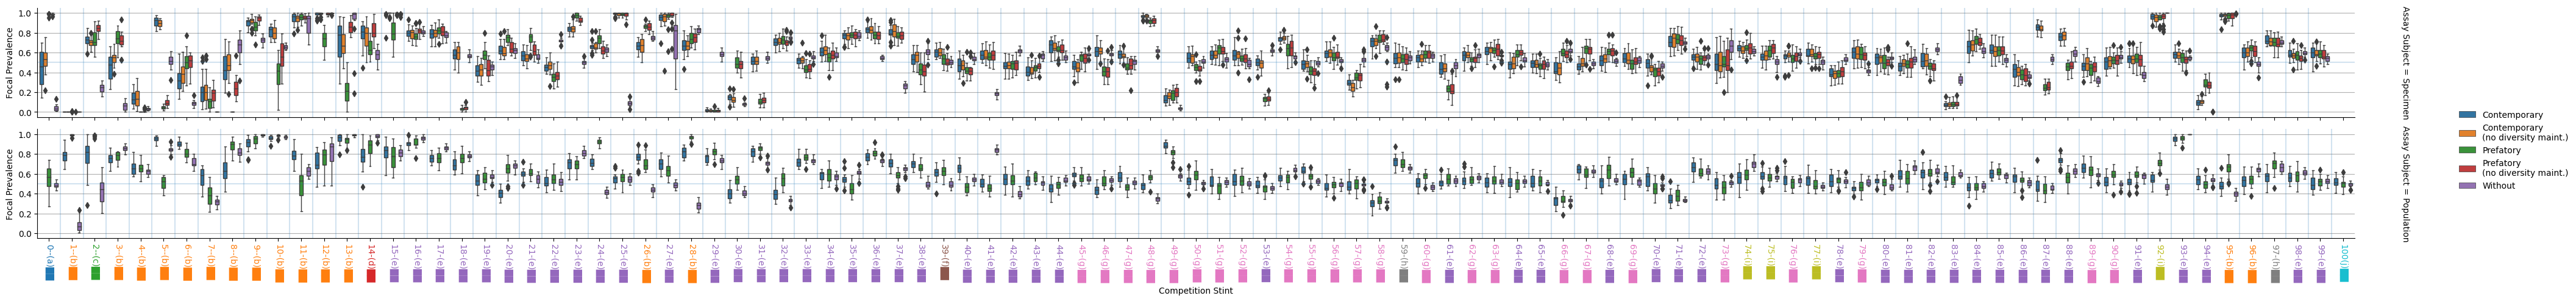

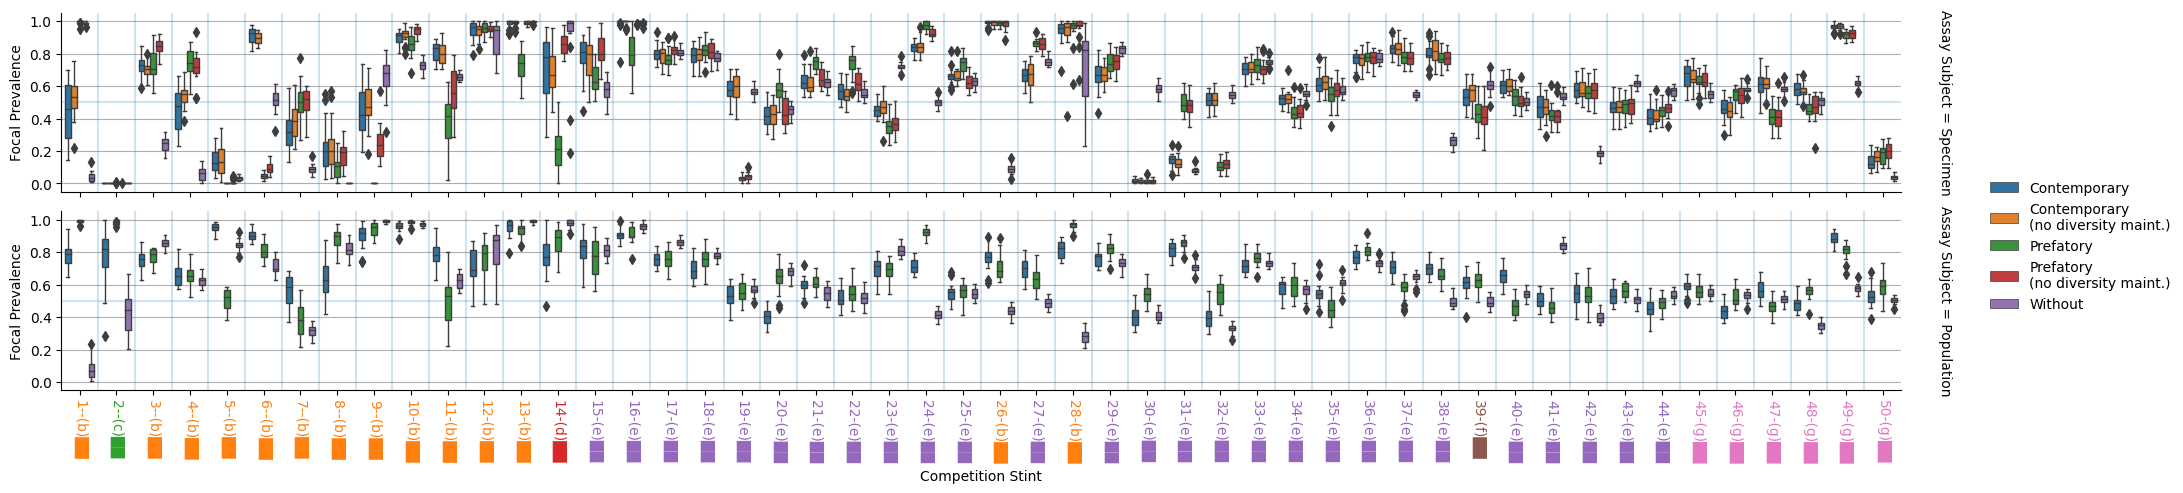

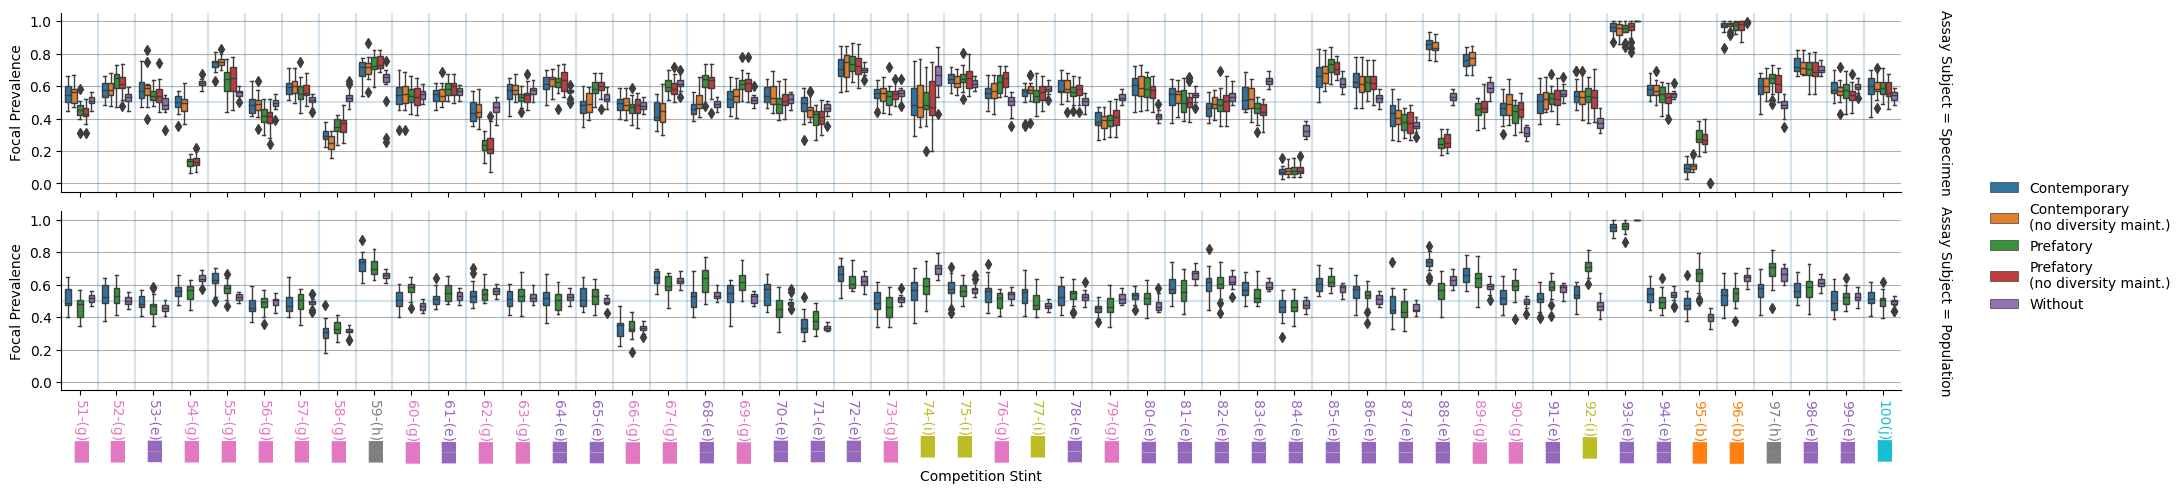

In [13]:
def boxplot(*args, **kwargs):
    ax = sns.boxplot(*args, **kwargs)
    plt.axhline(0.5, alpha=0.2)
    xmin, xmax = plt.gca().get_xlim()
    for x in range(int(xmin), int(xmax)):
        plt.axvline(x + 0.5, alpha=0.2)

    data = kwargs["data"]
    x = kwargs["x"]
    xticks = sorted(data[x].unique())
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in xticks)
    ax.tick_params(axis='x', labelrotation=270)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    
    for idx, tick in zip(xticks, ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_boxplot(data, x, y, hue):
    # see https://stackoverflow.com/a/52673435
    g = sns.FacetGrid(
        data, 
        row="Assay Subject", 
        margin_titles=True,
    )
    fig = g.map_dataframe(
        boxplot,
        x=x,
        y=y,
        hue=hue,
        hue_order=sorted(data["Biotic Background"].unique()),
        palette=sns.color_palette("tab10"),
        linewidth=1,
    )

    plt.gcf().set_size_inches(
        40 / 100 * len(data["Competition Stint"].unique()), 
        5,
    )
    plt.gcf().tight_layout()
    g.add_legend()

tp.tee(
    facet_boxplot,
    data=df[df['Root ID'] == 1],
    x='Competition Stint',
    y='Focal Prevalence',
    hue="Biotic Background",
)

# split in half
tp.tee(
    facet_boxplot,
    data=df[
        (df['Root ID'] == 1)
        & (1 <= df['Competition Stint'])
        & (df['Competition Stint'] <= 50)
    ],
    x='Competition Stint',
    y='Focal Prevalence',
    hue="Biotic Background",
    teeplot_outattrs={
        "stint": "1-50",
    }
)
tp.tee(
    facet_boxplot,
    data=df[
        (df['Root ID'] == 1)
        & (51 <= df['Competition Stint'])
        & (df['Competition Stint'] <= 100)
    ],
    x='Competition Stint',
    y='Focal Prevalence',
    hue="Biotic Background",
    teeplot_outattrs={
        "stint": "51-100",
    }
)


# updates barplot, boxplot

teeplots/hue=biotic-background+viz=facet-barplot+x=competition-stint+y=update+ext=.pdf
teeplots/hue=biotic-background+viz=facet-barplot+x=competition-stint+y=update+ext=.png
teeplots/hue=biotic-background+stint=1-50+viz=facet-barplot+x=competition-stint+y=update+ext=.pdf
teeplots/hue=biotic-background+stint=1-50+viz=facet-barplot+x=competition-stint+y=update+ext=.png
teeplots/hue=biotic-background+stint=51-100+viz=facet-barplot+x=competition-stint+y=update+ext=.pdf
teeplots/hue=biotic-background+stint=51-100+viz=facet-barplot+x=competition-stint+y=update+ext=.png


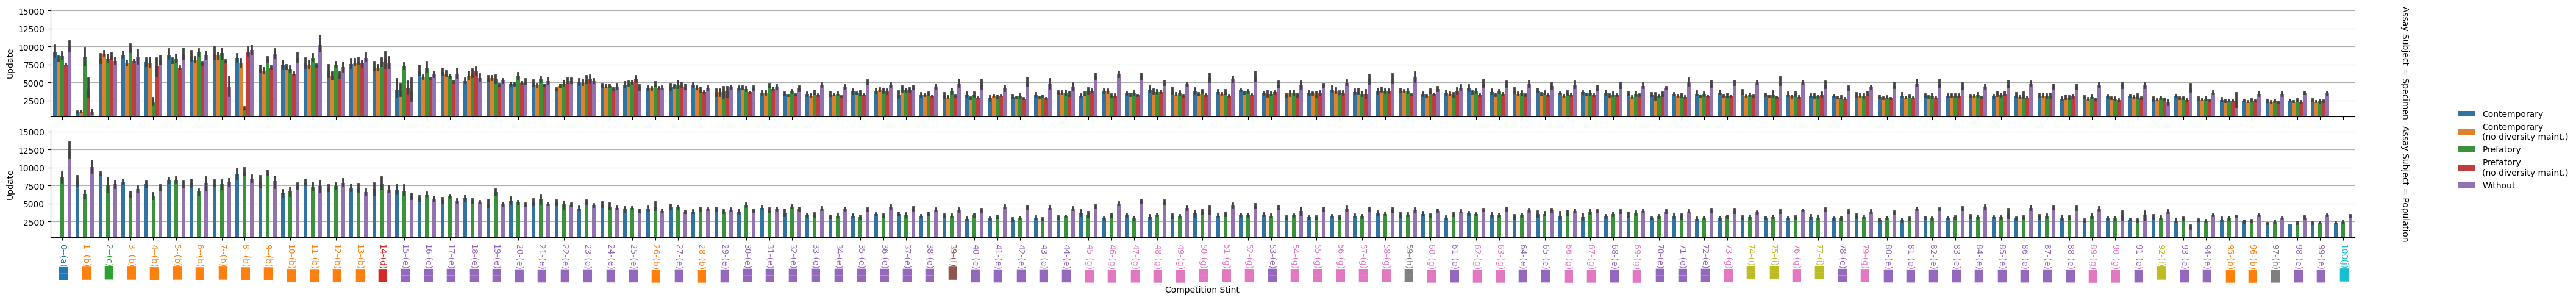

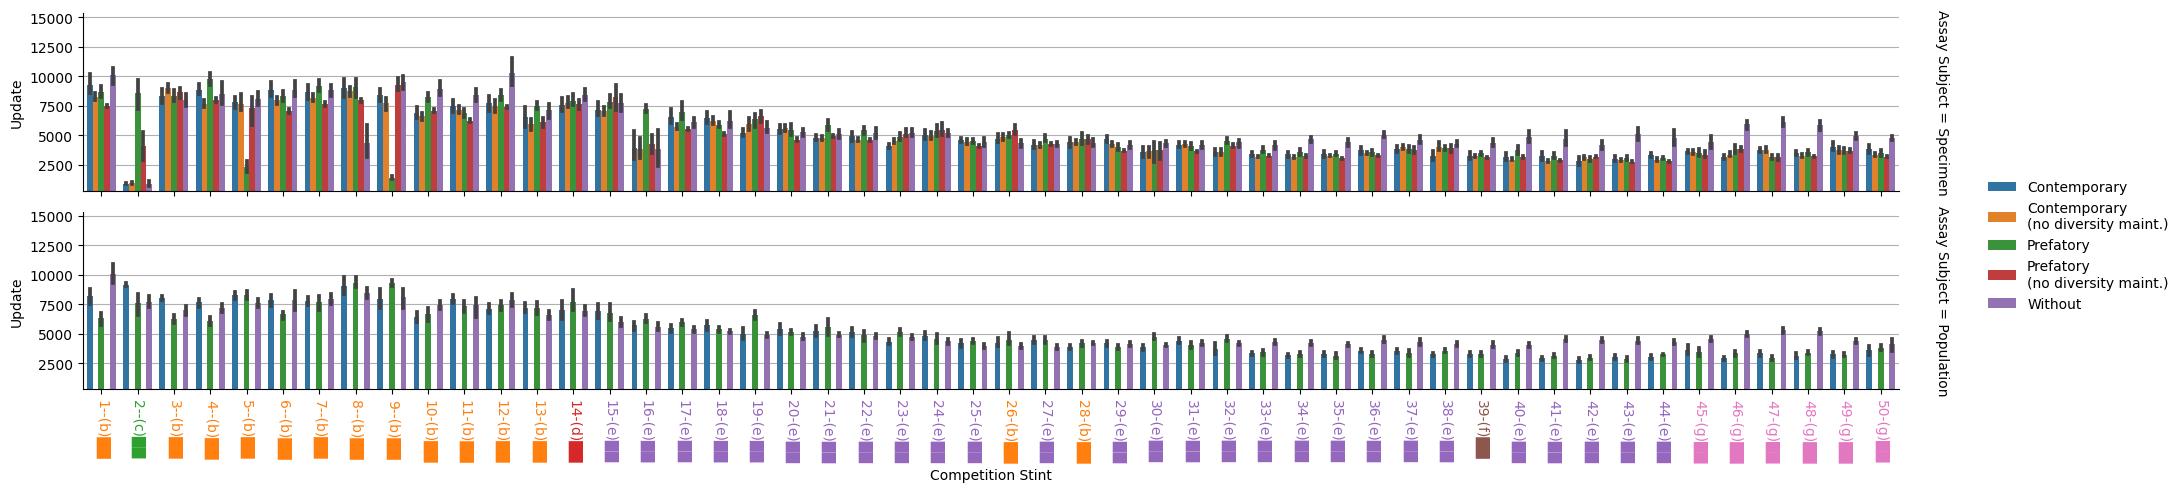

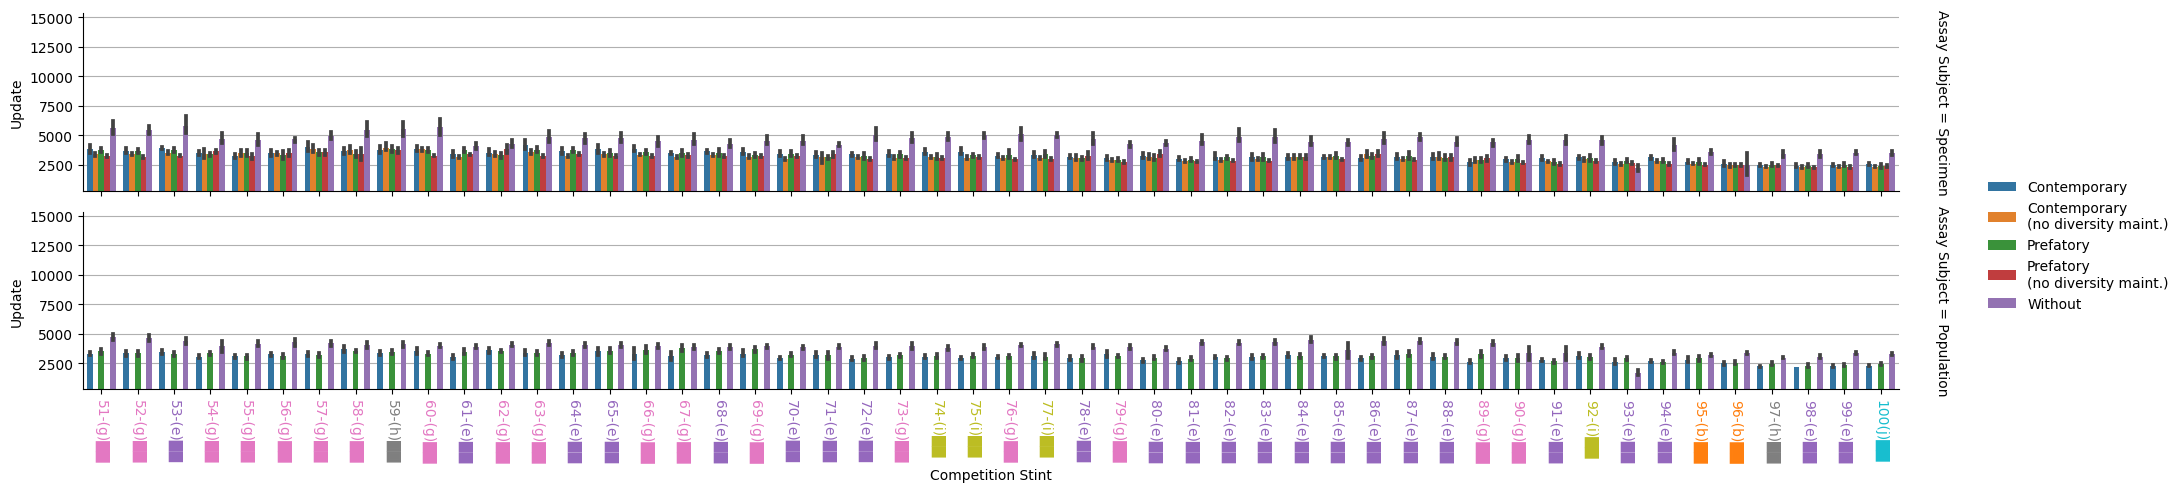

In [14]:
def barplot(*args, **kwargs):
    ax = sns.barplot(*args, ci=99, **kwargs)
    plt.axhline(0.5, alpha=0.2)

    data = kwargs["data"]
    x = kwargs["x"]
    xticks = sorted(data[x].unique())
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in xticks)
    ax.tick_params(axis='x', labelrotation=270)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    
    for idx, tick in zip(xticks, ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_barplot(data, x, y, hue):
    # see https://stackoverflow.com/a/52673435
    g = sns.FacetGrid(
        data, 
        row="Assay Subject", 
        margin_titles=True,
        ylim=(
            df["Update"].min(),
            df["Update"].max(),
        ),
    )
    fig = g.map_dataframe(
        barplot,
        x=x,
        y=y,
        hue=hue,
        hue_order=sorted(data["Biotic Background"].unique()),
        palette=sns.color_palette("tab10"),
    )

    plt.gcf().set_size_inches(
        40 / 100 * len(data["Competition Stint"].unique()), 
        5,
    )
    plt.gcf().tight_layout()
    g.add_legend()

tp.tee(
    facet_barplot,
    data=df[df['Root ID'] == 1],
    x='Competition Stint',
    y='Update',
    hue="Biotic Background",
)

# split in half
tp.tee(
    facet_barplot,
    data=df[
        (df['Root ID'] == 1)
        & (1 <= df['Competition Stint'])
        & (df['Competition Stint'] <= 50)
    ],
    x='Competition Stint',
    y='Update',
    hue="Biotic Background",
    teeplot_outattrs={
        "stint": "1-50",
    }
)
tp.tee(
    facet_barplot,
    data=df[
        (df['Root ID'] == 1)
        & (51 <= df['Competition Stint'])
        & (df['Competition Stint'] <= 100)
    ],
    x='Competition Stint',
    y='Update',
    hue="Biotic Background",
    teeplot_outattrs={
        "stint": "51-100",
    }
)


teeplots/hue=biotic-background+viz=facet-boxplot+x=competition-stint+y=update+ext=.pdf
teeplots/hue=biotic-background+viz=facet-boxplot+x=competition-stint+y=update+ext=.png
teeplots/hue=biotic-background+stint=1-50+viz=facet-boxplot+x=competition-stint+y=update+ext=.pdf
teeplots/hue=biotic-background+stint=1-50+viz=facet-boxplot+x=competition-stint+y=update+ext=.png
teeplots/hue=biotic-background+stint=51-100+viz=facet-boxplot+x=competition-stint+y=update+ext=.pdf
teeplots/hue=biotic-background+stint=51-100+viz=facet-boxplot+x=competition-stint+y=update+ext=.png


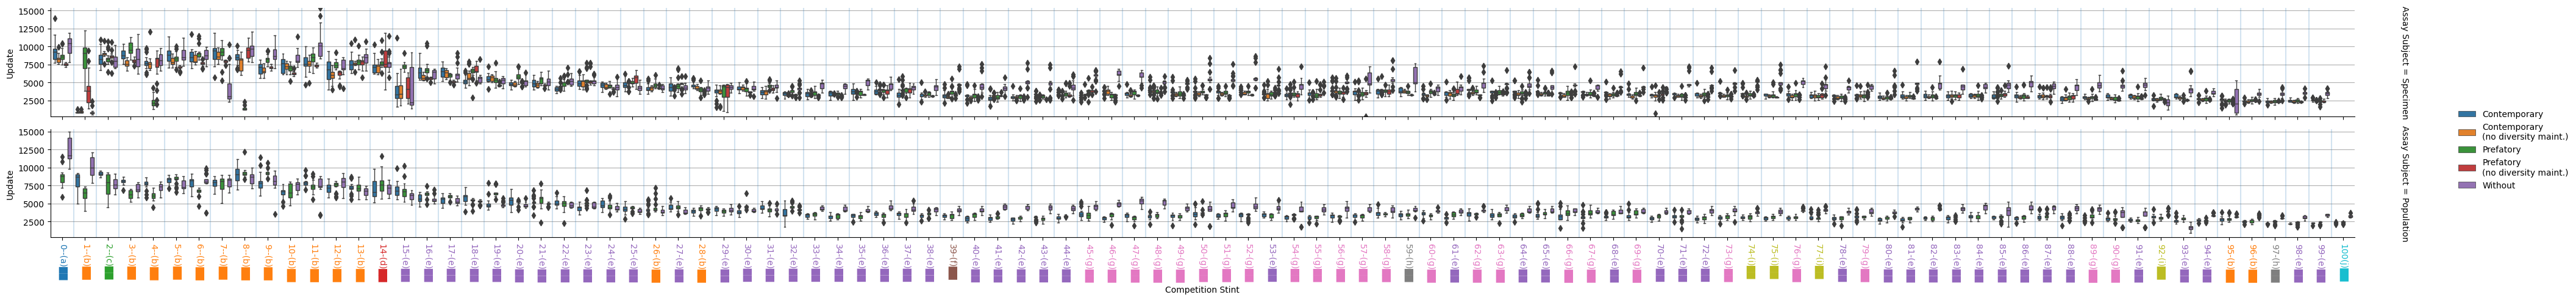

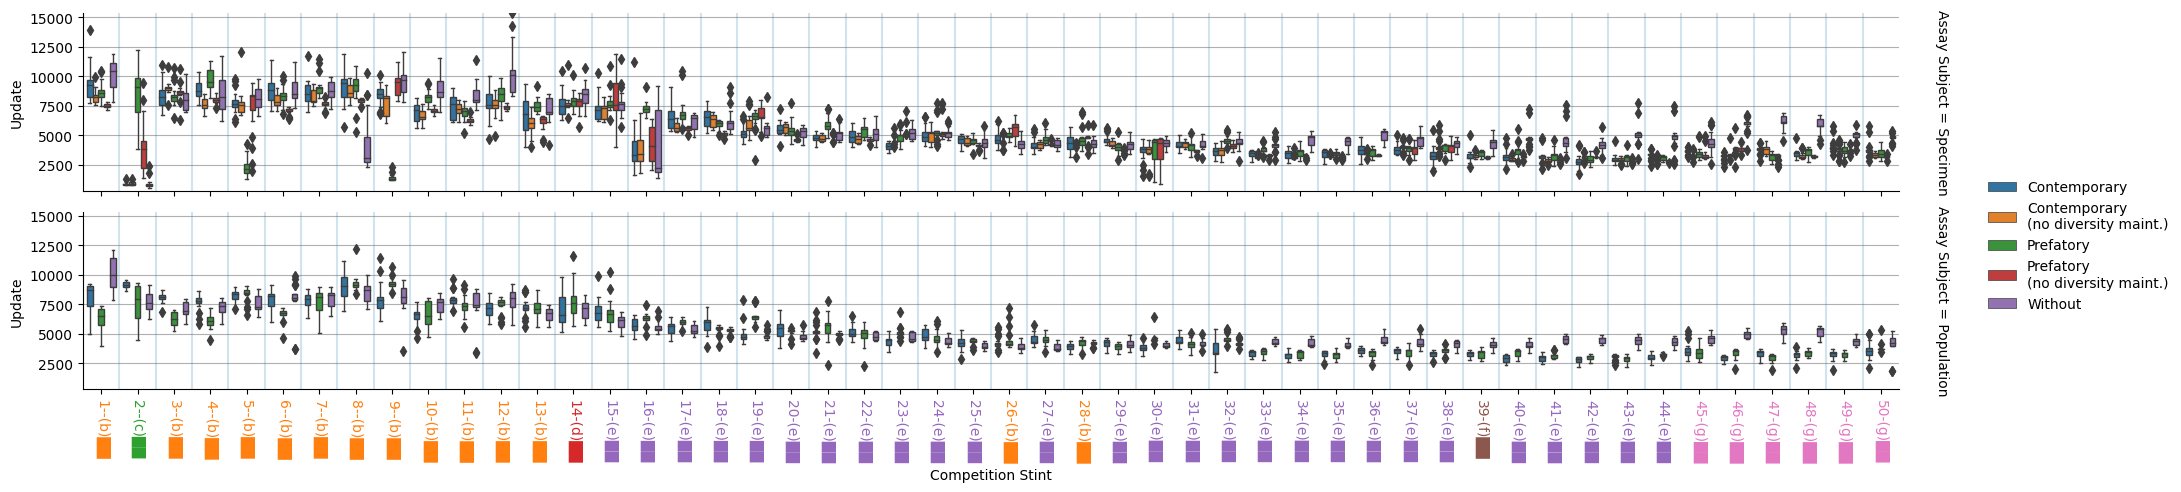

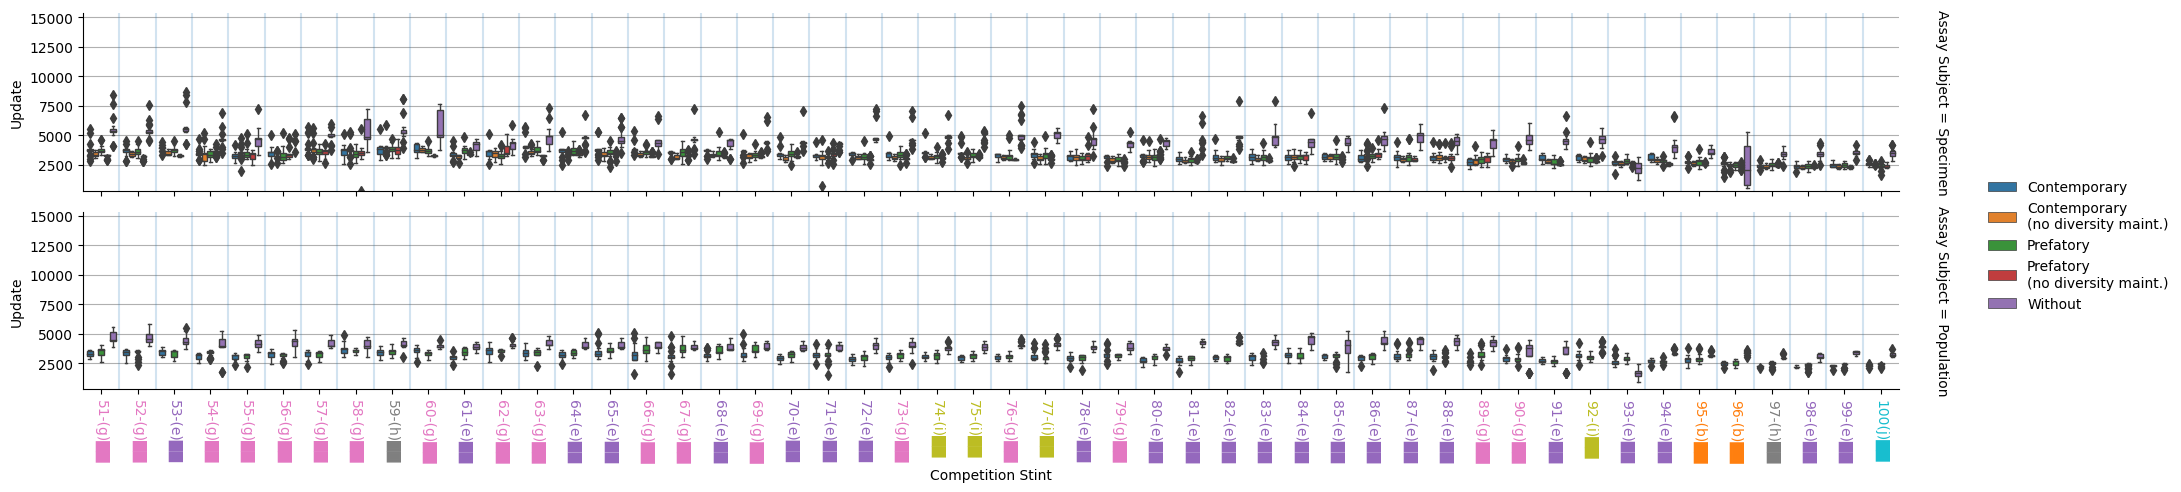

In [15]:
def boxplot(*args, **kwargs):
    ax = sns.boxplot(*args, **kwargs)
    plt.axhline(0.5, alpha=0.2)
    xmin, xmax = plt.gca().get_xlim()
    for x in range(int(xmin), int(xmax)):
        plt.axvline(x + 0.5, alpha=0.2)

    data = kwargs["data"]
    x = kwargs["x"]
    xticks = sorted(data[x].unique())
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in xticks)
    ax.tick_params(axis='x', labelrotation=270)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    
    for idx, tick in zip(xticks, ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_boxplot(data, x, y, hue):
    # see https://stackoverflow.com/a/52673435
    g = sns.FacetGrid(
        data, 
        row="Assay Subject", 
        margin_titles=True,
        ylim=(
            df["Update"].min(),
            df["Update"].max(),
        ),
    )
    fig = g.map_dataframe(
        boxplot,
        x=x,
        y=y,
        hue=hue,
        hue_order=sorted(data["Biotic Background"].unique()),
        palette=sns.color_palette("tab10"),
        linewidth=1,
    )

    plt.gcf().set_size_inches(
        40 / 100 * len(data["Competition Stint"].unique()), 
        5,
    )
    plt.gcf().tight_layout()
    g.add_legend()

tp.tee(
    facet_boxplot,
    data=df[df['Root ID'] == 1],
    x='Competition Stint',
    y='Update',
    hue="Biotic Background",
)

# split in half
tp.tee(
    facet_boxplot,
    data=df[
        (df['Root ID'] == 1)
        & (1 <= df['Competition Stint'])
        & (df['Competition Stint'] <= 50)
    ],
    x='Competition Stint',
    y='Update',
    hue="Biotic Background",
    teeplot_outattrs={
        "stint": "1-50",
    }
)
tp.tee(
    facet_boxplot,
    data=df[
        (df['Root ID'] == 1)
        & (51 <= df['Competition Stint'])
        & (df['Competition Stint'] <= 100)
    ],
    x='Competition Stint',
    y='Update',
    hue="Biotic Background",
    teeplot_outattrs={
        "stint": "51-100",
    }
)


# significant fitness gain/loss heatmap

teeplots/hue=fitness-gain-or-loss+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.pdf
teeplots/hue=fitness-gain-or-loss+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.png


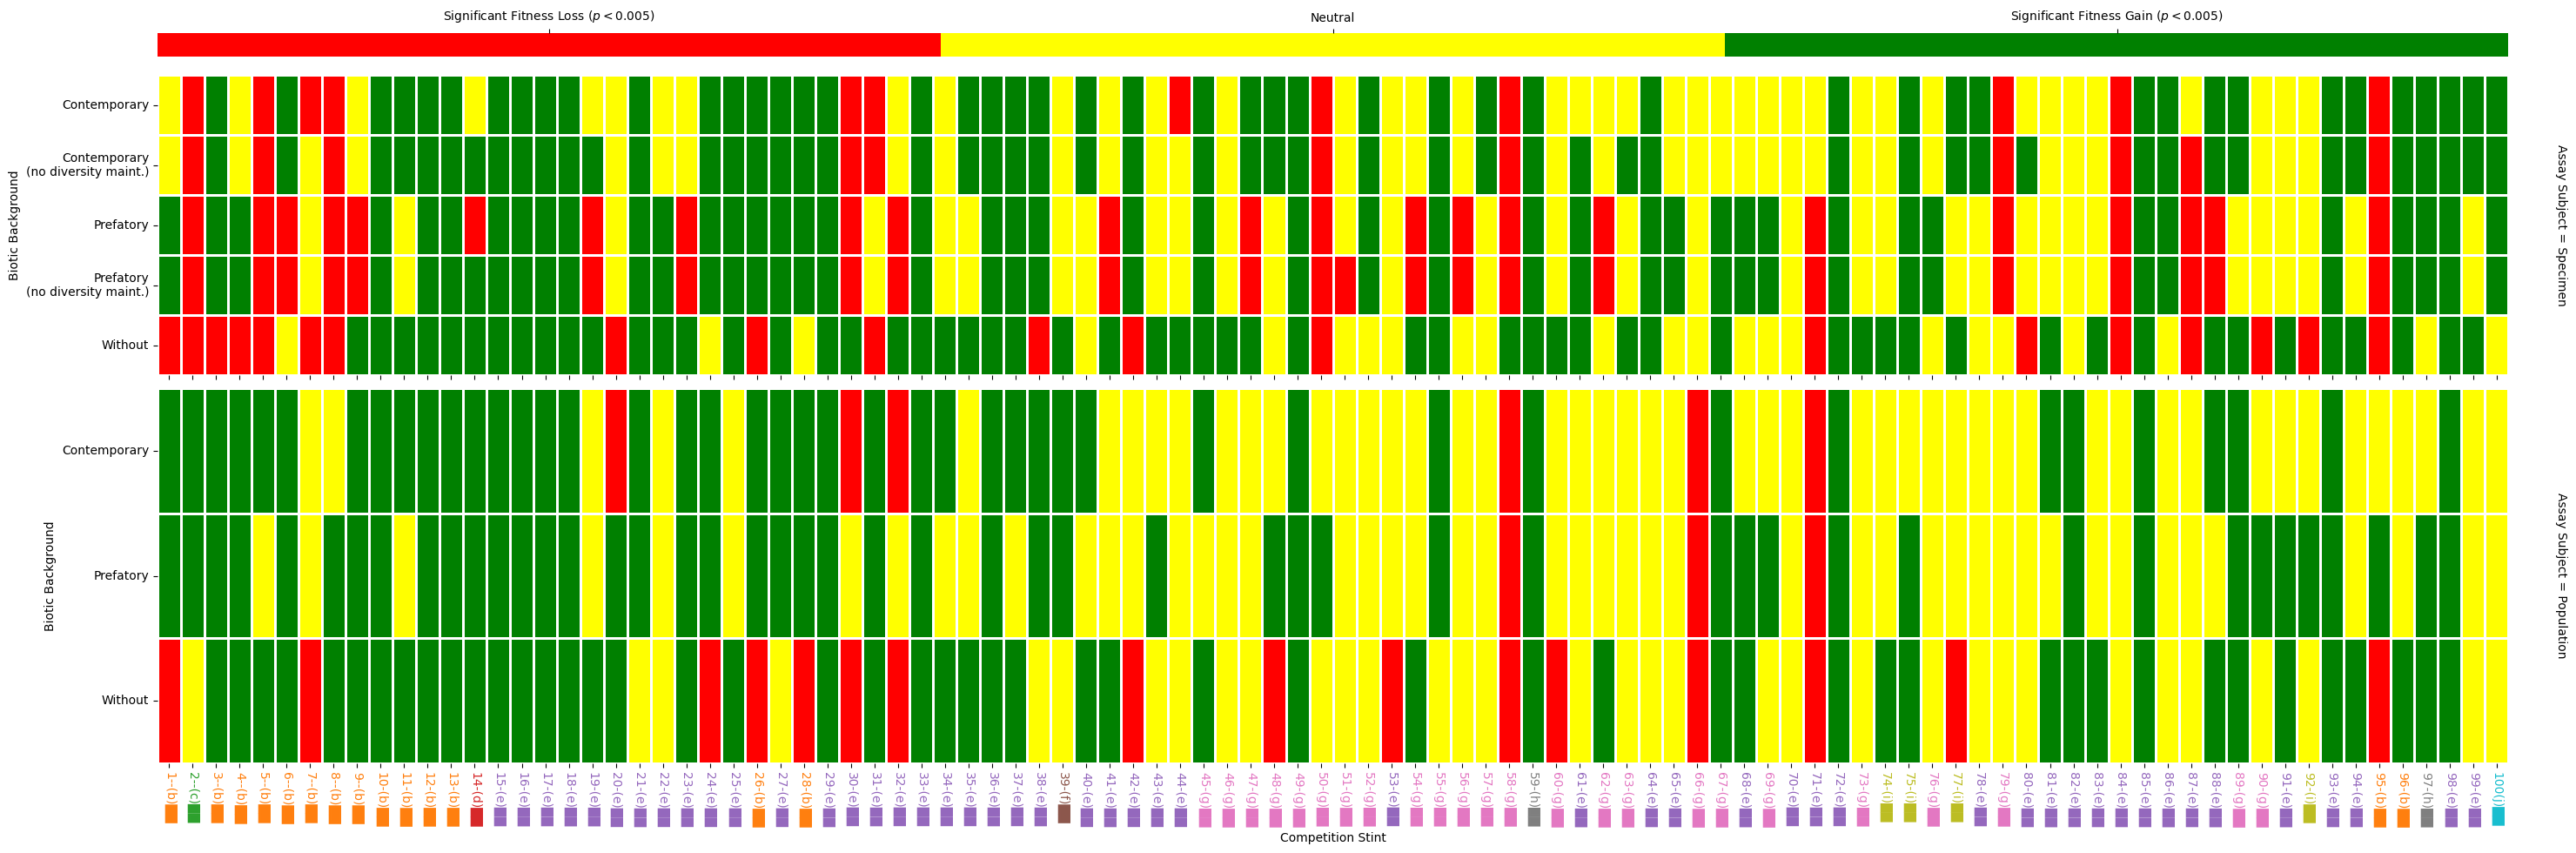

In [16]:
# adapted from https://stackoverflow.com/a/38887138
colors = ('red', 'yellow', 'green')
cmap = mpl_LinearSegmentedColormap.from_list('Custom', colors, len(colors))

def plot_heatmap(data, **kwargs):
    win_df = data[
        (data["Root ID"] == 1) 
        & (data["Competition Stint"] > 0)
    ].groupby(
        ["Biotic Background", "Competition Stint"]
    )['Positive Fitness Differential Focal'].agg([len, sum]).reset_index()

    win_df["Outcome"] = win_df.apply(
        lambda row: -1 if row["sum"] < 3 else 1 if row["sum"] > 17 else 0,
        axis=1,
    ) 
    assert set(win_df["len"]) == {20}
    
    pivot_df = win_df.pivot("Biotic Background", "Competition Stint", "Outcome")
    
    ax = sns.heatmap(pivot_df, cmap=cmap, cbar_kws={"location": "top", "aspect": 100, "shrink": 1.0}, linewidth=1)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    colorbar.set_ticklabels(['Significant Fitness Loss $(p < 0.005)$', 'Neutral', 'Significant Fitness Gain $(p < 0.005)$'])
    if {*data["Assay Subject"].unique()} == {"Population"}:
        colorbar.remove()
    
    ax.set_xticks(np.array(range(100)) + 0.5)
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in range(1, 101))
    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(axis='x', labelrotation=270)
    
    for idx, tick in enumerate(ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx+1]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_heatmap(data, x, y, hue):
    g = sns.FacetGrid(df, sharey=False, row="Assay Subject", margin_titles=True)
    fig = g.map_dataframe(plot_heatmap)

    plt.gcf().set_size_inches(30, 10)
    plt.gcf().tight_layout()

tp.tee(
    facet_heatmap,
    data=df[df['Root ID'] == 1],
    x="Biotic Background",
    y="Competition Stint",
    hue="Fitness Gain or Loss",
)


# competition prevalence heatmap

teeplots/hue=mean-competition-prevalence+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.pdf
teeplots/hue=mean-competition-prevalence+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.png


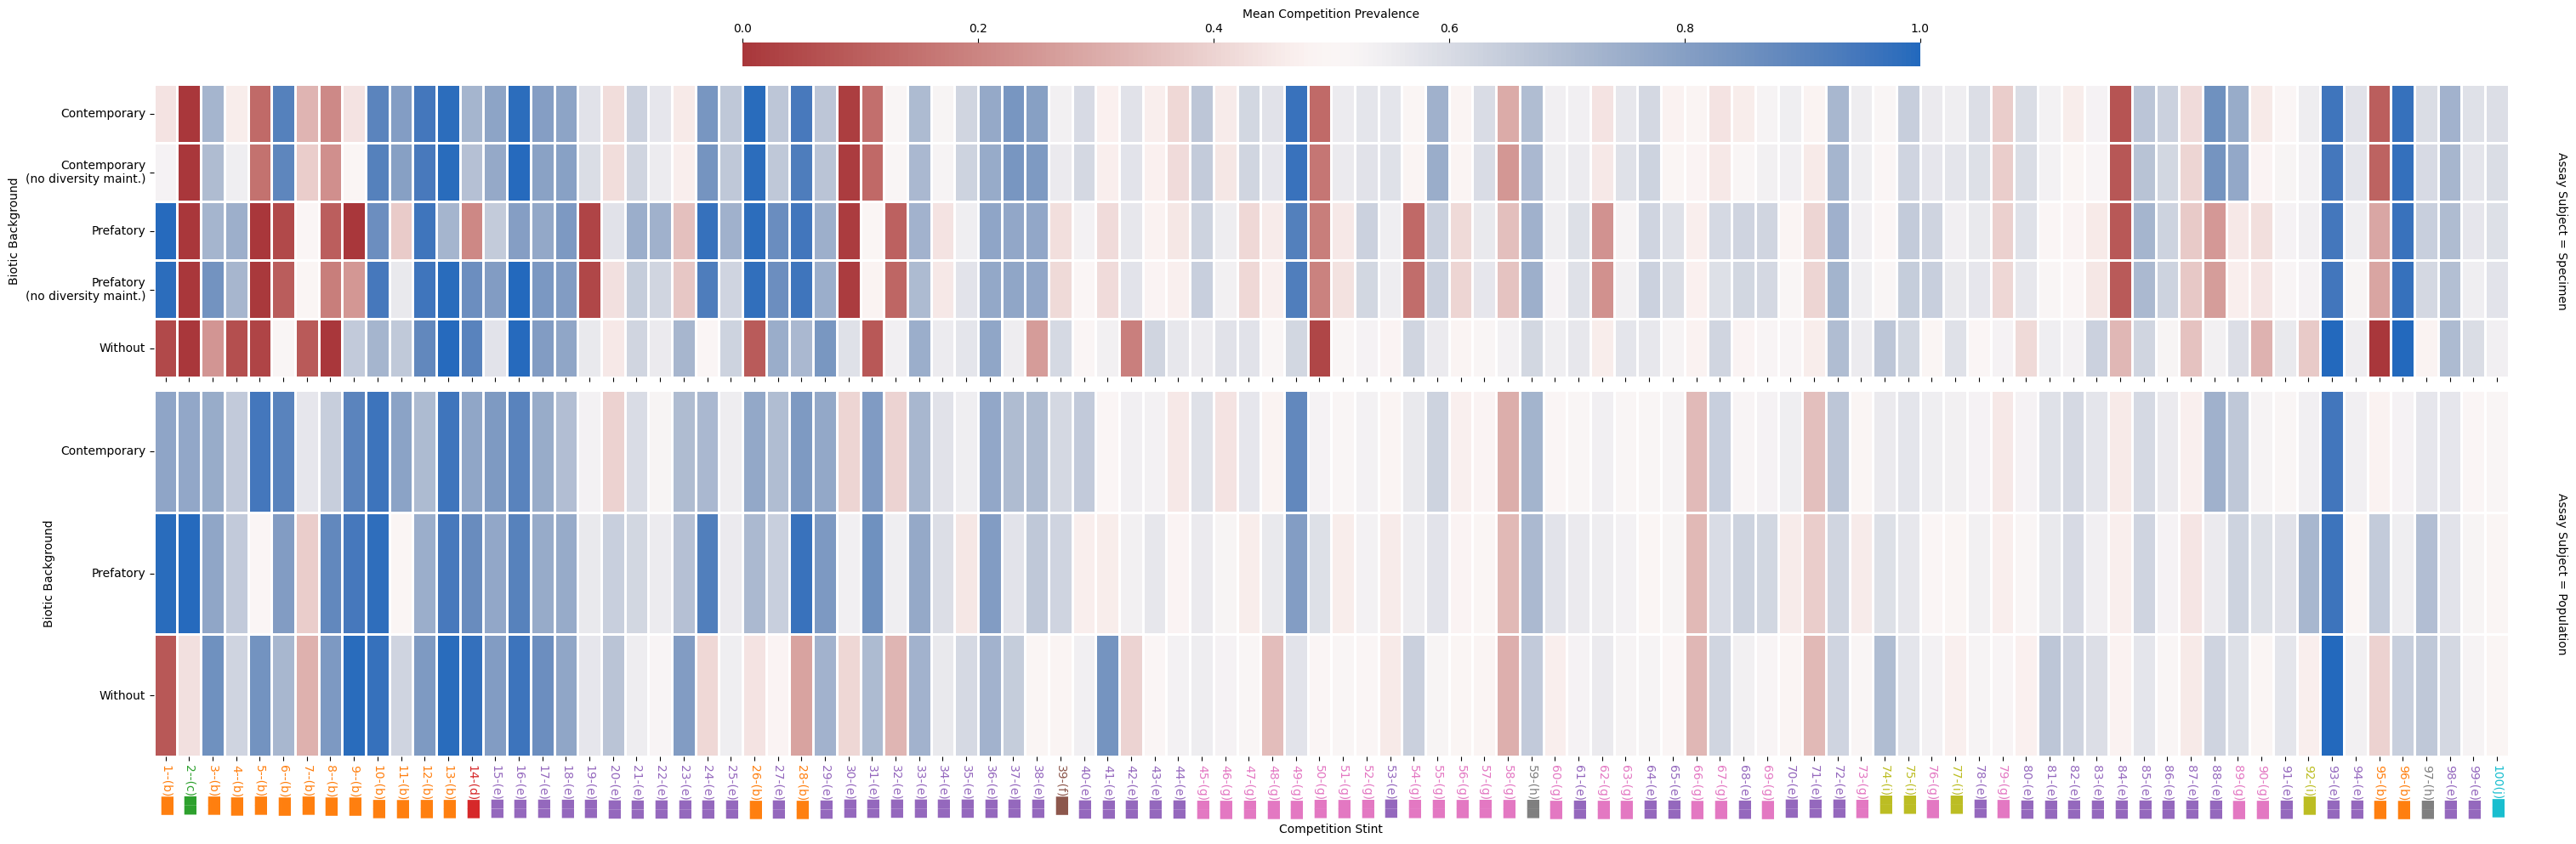

In [17]:
def plot_heatmap(data, **kwargs):
    win_df = data[
        (data["Root ID"] == 1) 
        & (data["Competition Stint"] > 0)
    ].groupby(
        ["Biotic Background", "Competition Stint"]
    )['Focal Prevalence'].mean().reset_index()

    win_df["Outcome"] = win_df["Focal Prevalence"]
    
    pivot_df = win_df.pivot("Biotic Background", "Competition Stint", "Outcome")
    
    ax = sns.heatmap(
        pivot_df, 
        cmap="vlag_r", 
        cbar_kws={
            "label": "Mean Competition Prevalence", 
            "location": "top", 
            "aspect": 50, 
            "shrink": 0.5,
        }, 
        linewidth=1,
        vmin=0, 
        vmax=1,
    )
    colorbar = ax.collections[0].colorbar
    if {*data["Assay Subject"].unique()} == {"Population"}:
        colorbar.remove()
    
    ax.set_xticks(np.array(range(100)) + 0.5)
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in range(1, 101))
    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(axis='x', labelrotation=270)
    
    for idx, tick in enumerate(ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx+1]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_heatmap(data, x, y, hue):
    g = sns.FacetGrid(df, sharey=False, row="Assay Subject", margin_titles=True)
    fig = g.map_dataframe(plot_heatmap)

    plt.gcf().set_size_inches(30, 10)
    plt.gcf().tight_layout()

tp.tee(
    facet_heatmap,
    data=df[df['Root ID'] == 1],
    x="Biotic Background",
    y="Competition Stint",
    hue="Mean Competition Prevalence",
)


# Fitness Differential Heatmap

teeplots/hue=median-fitness-differential+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.pdf
teeplots/hue=median-fitness-differential+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.png


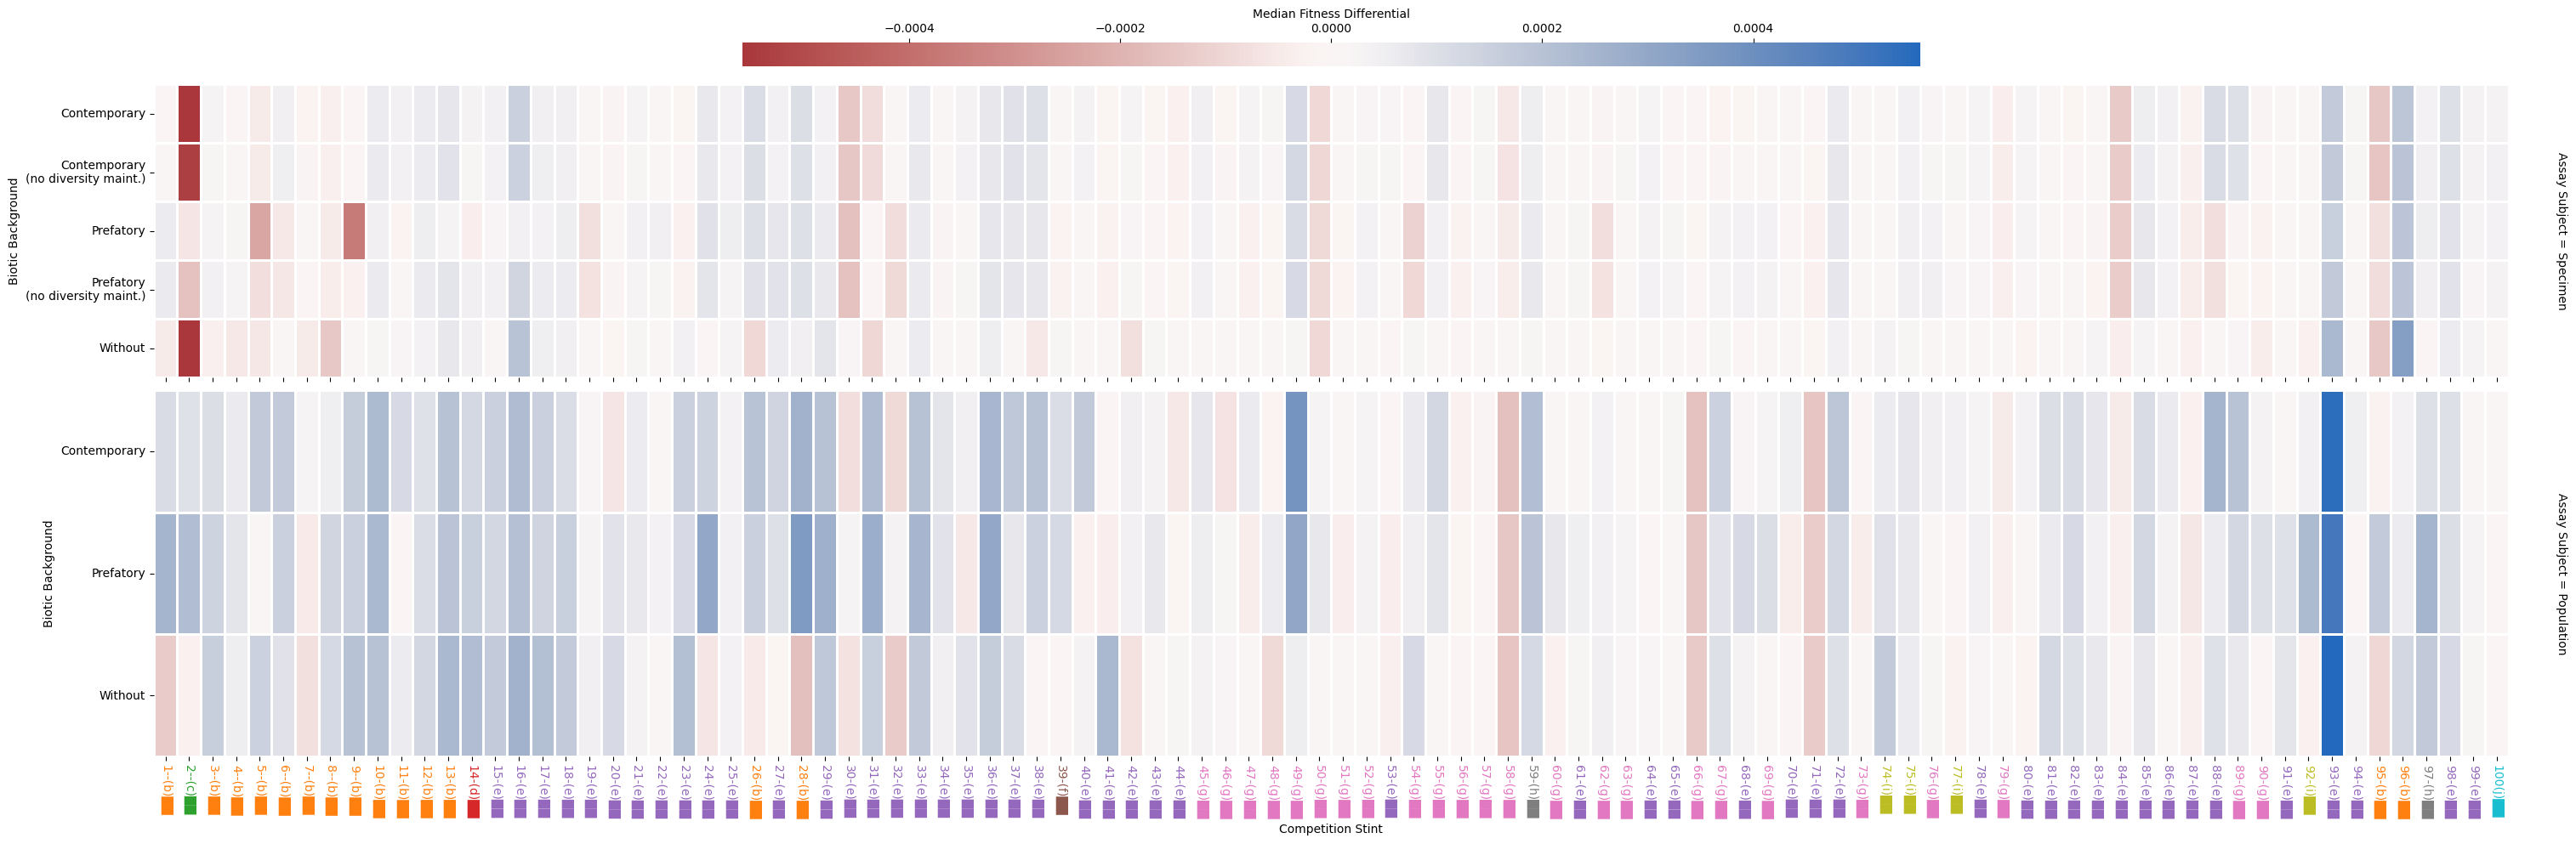

In [18]:
def plot_heatmap(data, **kwargs):
    win_df = data[
        (data["Root ID"] == 1) 
        & (data["Competition Stint"] > 0)
    ].groupby(
        ["Biotic Background", "Competition Stint"]
    )['Fitness Differential Focal'].mean().reset_index()

    win_df["Outcome"] = win_df["Fitness Differential Focal"]
    
    pivot_df = win_df.pivot("Biotic Background", "Competition Stint", "Outcome")
    
    global_extremum = data.groupby(
        ["Biotic Background", "Competition Stint"],
    )['Fitness Differential Focal'].median().abs().max() 
    ax = sns.heatmap(
        pivot_df,
        cmap="vlag_r",
        cbar_kws={"label": "Median Fitness Differential", "location": "top", "aspect": 50, "shrink": 0.5},
        linewidth=1,
        vmin=-global_extremum,
        vmax=global_extremum,
    )
    colorbar = ax.collections[0].colorbar
    if {*data["Assay Subject"].unique()} == {"Population"}:
        colorbar.remove()
    
    ax.set_xticks(np.array(range(100)) + 0.5)
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in range(1, 101))
    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(axis='x', labelrotation=270)
    
    for idx, tick in enumerate(ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx+1]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_heatmap(data, x, y, hue):
    g = sns.FacetGrid(df, sharey=False, row="Assay Subject", margin_titles=True)
    fig = g.map_dataframe(plot_heatmap)

    plt.gcf().set_size_inches(30, 10)
    plt.gcf().tight_layout()

tp.tee(
    facet_heatmap,
    data=df[df['Root ID'] == 1],
    x="Biotic Background",
    y="Competition Stint",
    hue="Median Fitness Differential",
)


teeplots/hue=symlog-median-fitness-differential+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.pdf
teeplots/hue=symlog-median-fitness-differential+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.png


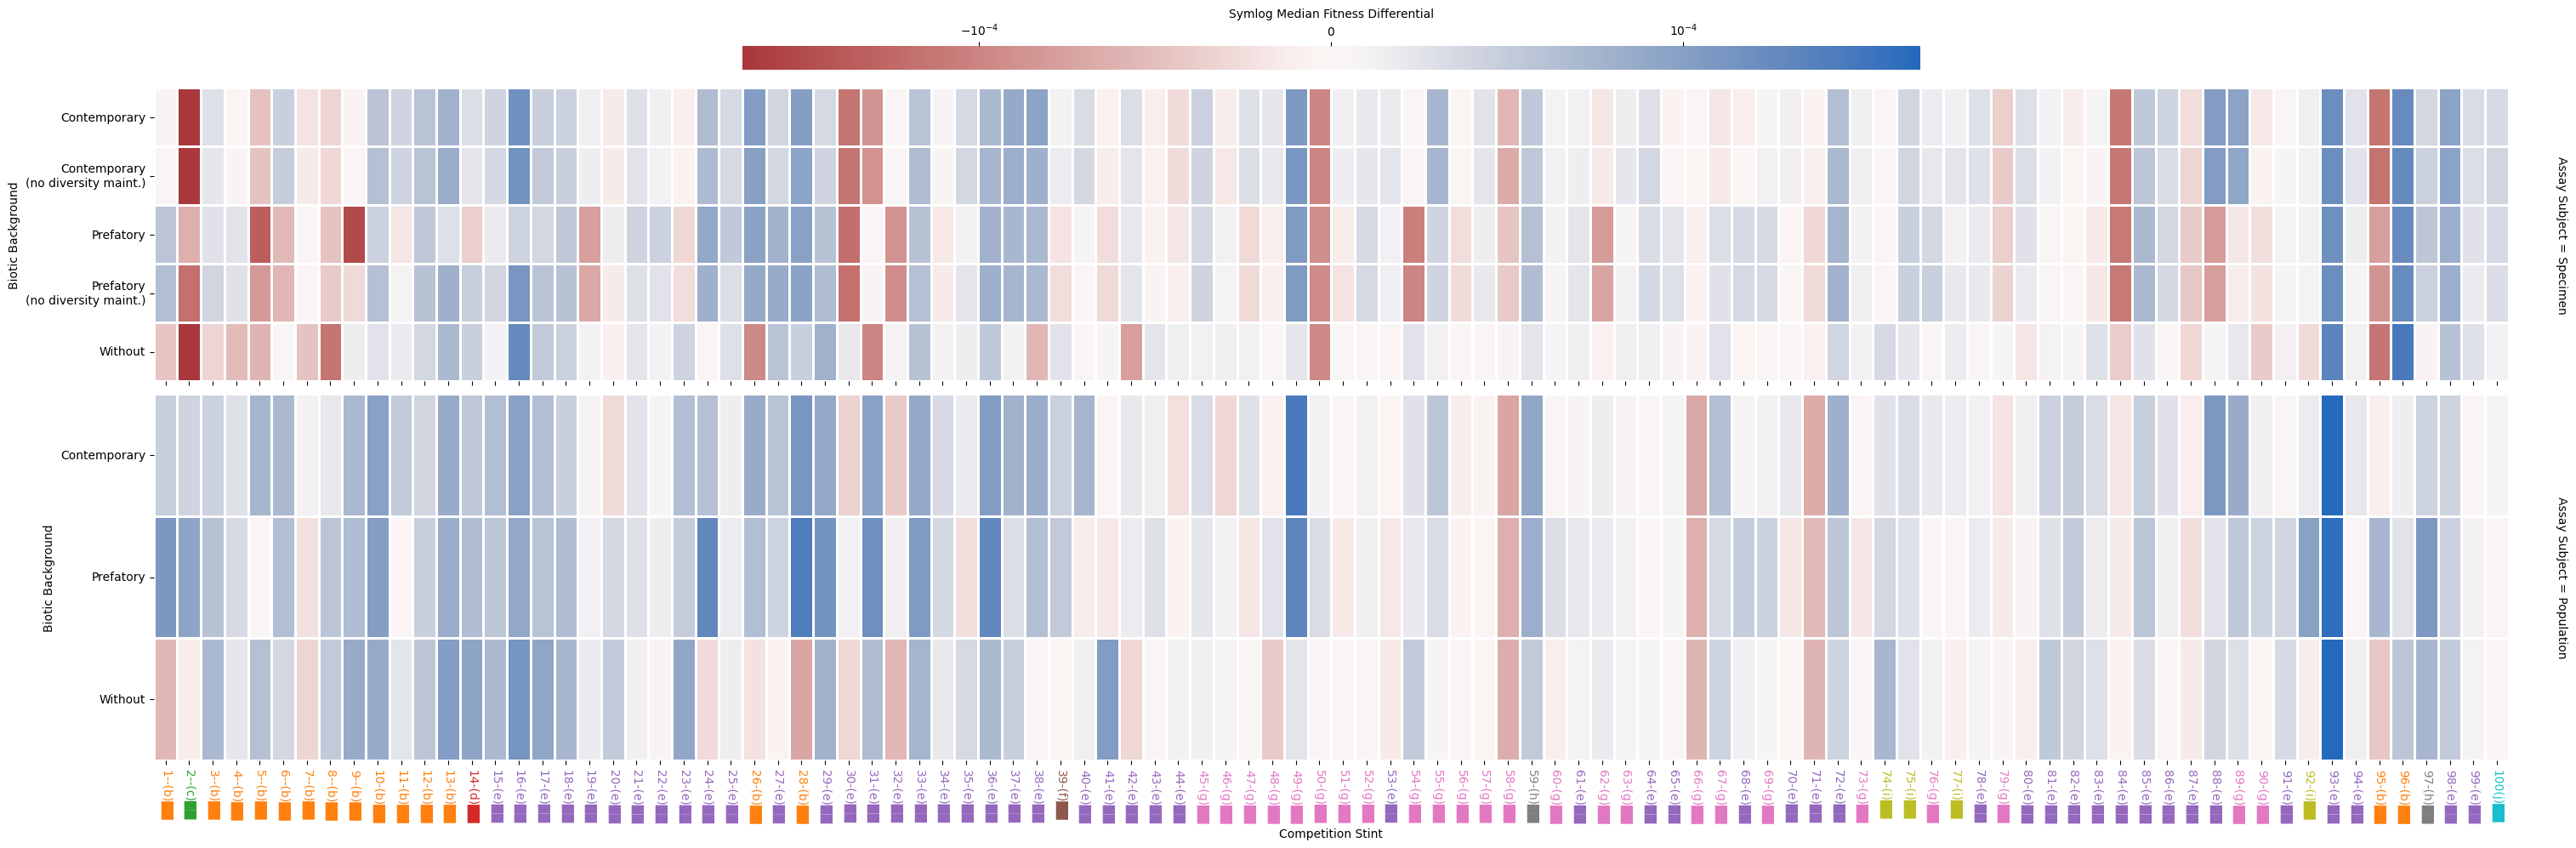

In [19]:
def plot_heatmap(data, **kwargs):
    win_df = data[
        (data["Root ID"] == 1) 
        & (data["Competition Stint"] > 0)
    ].groupby(
        ["Biotic Background", "Competition Stint"]
    )['Fitness Differential Focal'].mean().reset_index()

    win_df["Outcome"] = win_df["Fitness Differential Focal"]
    
    pivot_df = win_df.pivot("Biotic Background", "Competition Stint", "Outcome")
    
    global_extremum = data.groupby(
        ["Biotic Background", "Competition Stint"],
    )['Fitness Differential Focal'].median().abs().max() 
    ax = sns.heatmap(
        pivot_df,
        cmap="vlag_r",
        cbar_kws={"label": "Symlog Median Fitness Differential", "location": "top", "aspect": 50, "shrink": 0.5},
        linewidth=1,
        norm=mpl_SymLogNorm(
            linthresh=1e-4,
            vmin=-global_extremum,
            vmax=global_extremum,
        ),
    )
    colorbar = ax.collections[0].colorbar
    if {*data["Assay Subject"].unique()} == {"Population"}:
        colorbar.remove()
    
    ax.set_xticks(np.array(range(100)) + 0.5)
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in range(1, 101))
    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(axis='x', labelrotation=270)
    
    for idx, tick in enumerate(ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx+1]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_heatmap(data, x, y, hue):
    g = sns.FacetGrid(df, sharey=False, row="Assay Subject", margin_titles=True)
    fig = g.map_dataframe(plot_heatmap)

    plt.gcf().set_size_inches(30, 10)
    plt.gcf().tight_layout()

tp.tee(
    facet_heatmap,
    data=df[df['Root ID'] == 1],
    x="Biotic Background",
    y="Competition Stint",
    hue="Symlog Median Fitness Differential",
)


# updates elapsed heatmap

teeplots/hue=num-updates-elapsed+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.pdf
teeplots/hue=num-updates-elapsed+viz=facet-heatmap+x=biotic-background+y=competition-stint+ext=.png


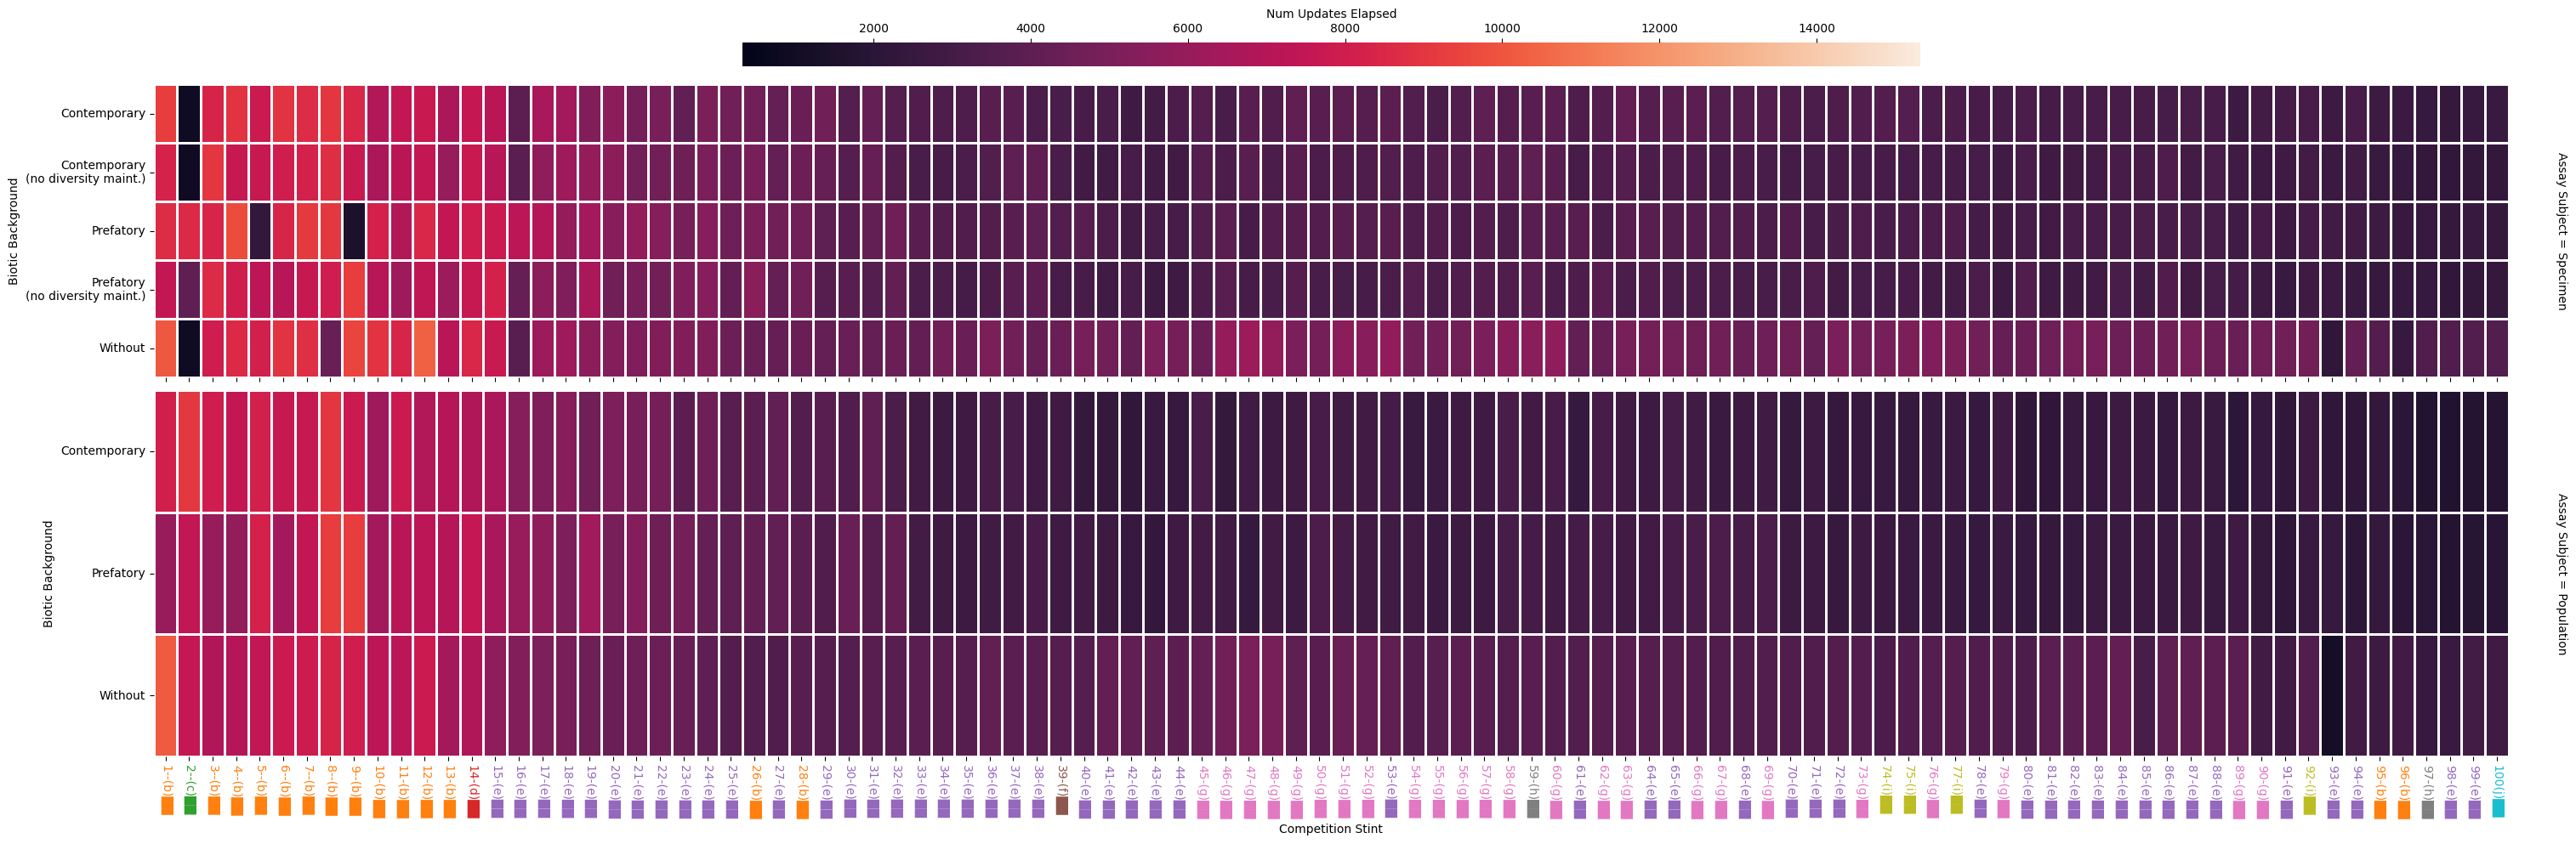

In [20]:
def plot_heatmap(data, **kwargs):
    win_df = data[
        (data["Root ID"] == 1) 
        & (data["Competition Stint"] > 0)
    ].groupby(
        ["Biotic Background", "Competition Stint"]
    )['Update'].mean().reset_index()

    win_df["Outcome"] = win_df["Update"]
    
    pivot_df = win_df.pivot("Biotic Background", "Competition Stint", "Outcome")
    
    ax = sns.heatmap(
        pivot_df, 
        cbar_kws={
            "label": "Num Updates Elapsed",
            "location": "top",
            "aspect": 50,
            "shrink": 0.5,
        }, 
        linewidth=1,
        vmin=data["Update"].min(), 
        vmax=data["Update"].max(),

    )
    colorbar = ax.collections[0].colorbar
    if {*data["Assay Subject"].unique()} == {"Population"}:
        colorbar.remove()
    ax.set_xticks(np.array(range(100)) + 0.5)
    ax.set_xticklabels(f"{i:{'-'}{'<'}{3}}({morph_key[i]})██" for i in range(1, 101))
    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(axis='x', labelrotation=270)
    
    for idx, tick in enumerate(ax.get_xticklabels()):
        tick.set_color(color_key[morph_key[idx+1]])
        tick.set_fontfamily("monospace")
        tick.set_fontname("Fira Mono")

def facet_heatmap(data, x, y, hue):
    g = sns.FacetGrid(df, sharey=False, row="Assay Subject", margin_titles=True)
    fig = g.map_dataframe(plot_heatmap)

    plt.gcf().set_size_inches(30, 10)
    plt.gcf().tight_layout()

tp.tee(
    facet_heatmap,
    data=df[df['Root ID'] == 1],
    x="Biotic Background",
    y="Competition Stint",
    hue="Num Updates Elapsed",
)


# outcomes countplot

In [21]:
def _do_barlabel_catplot(*args, **kwargs):
    def bgcolor_lookup(title): 
        if "Fit Loss" in title:
            return "red"
        elif "Neutral" in title:
            return "yellow"
        elif "Fit Gain" in title:
            return "green"
        else:
            raise ValueError

    def color_lookup(title): 
        if "Fit Loss" in title:
            return "white"
        elif "Neutral" in title:
            return "black"
        elif "Fit Gain" in title:
            return "white"
        else:
            raise ValueError
    
    g = sns.catplot(
        *args,
        **kwargs,
        legend_out=False,
    )
    for ax in g.axes.flat:
        ax.set_title(
            ax.get_title(
            ).replace(
                '\n',
                ' ',
            ).replace(
                ' = ',
                '\n',
            ).replace(
                ' Biotic',
                '\nBiotic',
            ).replace(
                ' (',
                '\n(',
            )
        )

        try:
            ax.title.set_color(color_lookup(ax.get_title()))
            ax.title.set_backgroundcolor(bgcolor_lookup(ax.get_title()))
            ax.title.set_weight("bold")
            ax.title.set_ha("center")
        except ValueError:
            pass

        for text in ax.texts:
            text.set_text(
                text.get_text(
                ).replace(
                    '\n',
                    ' ',
                ).replace(
                    ' = ',
                    '\n',
                ).replace(
                    ' Biotic',
                    '\nBiotic',
                ).replace(
                    ' (',
                    '\n(',
                )
            )
            try:
                text.set_color(color_lookup(text.get_text()))
                text.set_backgroundcolor(bgcolor_lookup(text.get_text()))
                text.set_weight("bold")
                text.set_va("center")
                text.set_ha("bottom")
            except ValueError:
                pass

        for item in ax.containers:
            ax.bar_label(item)

        if "hue" in kwargs:
            for ax in g.axes.flat:
                ax.legend(frameon=False, title=kwargs["hue"])
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

def barlabel_catplot(*args, **kwargs):
    _do_barlabel_catplot(*args, **kwargs)
    plt.gcf().set_size_inches(
        *[
            0.5 * d
            for d in plt.gcf().get_size_inches()
        ]
    )
            

teeplots/col=biotic-background+kind=count+row=assay-subject+viz=barlabel-catplot+x=outcome+ext=.pdf
teeplots/col=biotic-background+kind=count+row=assay-subject+viz=barlabel-catplot+x=outcome+ext=.png


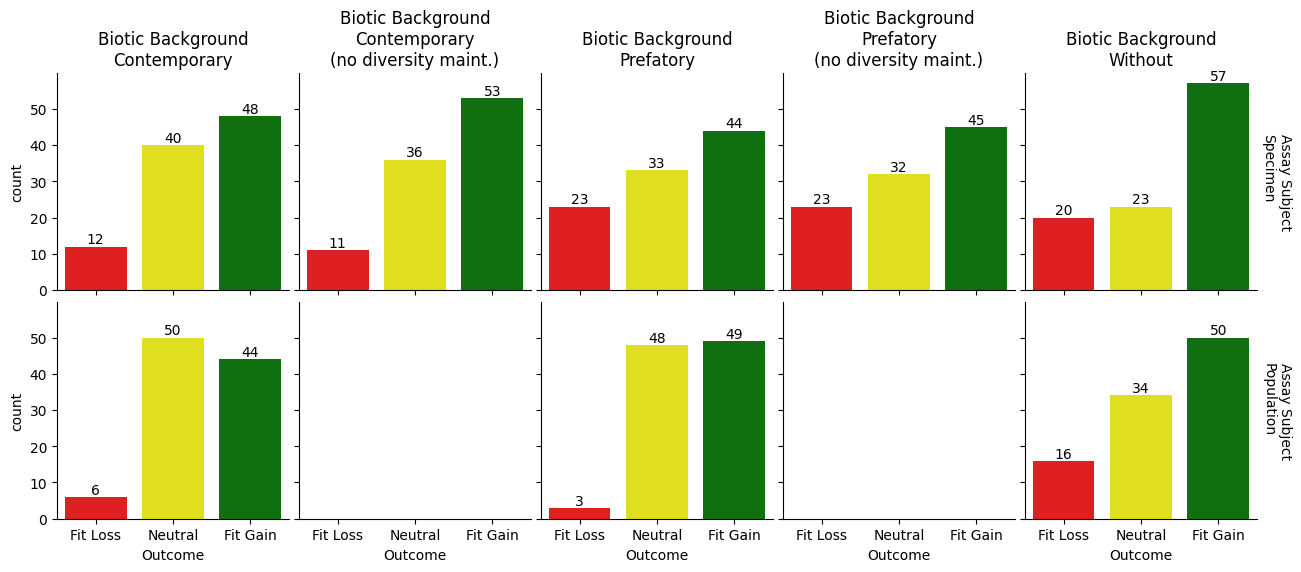

In [22]:
order = [
    "Fit Loss",
    "Neutral",
    "Fit Gain",
]
palette = [
    "red", 
    "yellow",
    "green",    
]

win_df = df[
    (df["Root ID"] == 1) 
    & (df["Competition Stint"] > 0)
].groupby(
    ["Biotic Background", "Competition Stint", "Assay Subject"]
)['Positive Fitness Differential Focal'].agg([len, sum]).reset_index()

win_df["Outcome"] = win_df.apply(
    lambda row: "Fit Loss" if row["sum"] < 3 else "Fit Gain" if row["sum"] > 17 else "Neutral",
    axis=1,
) 
assert set(win_df["len"]) == {20}

tp.tee(
    barlabel_catplot,
    data=win_df,
    x="Outcome",
    col="Biotic Background",
    row_order=[
        "Specimen",
        "Population",
    ],
    row="Assay Subject",
    order=order,
    hue_order=order,
    palette=palette,
    kind="count",
    margin_titles=True,
)


teeplots/assay-subject=Population+col=contemporary-biotic-background+kind=count+row=prefatory-biotic-background+viz=barlabel-catplot+x=without-biotic-background+ext=.pdf
teeplots/assay-subject=Population+col=contemporary-biotic-background+kind=count+row=prefatory-biotic-background+viz=barlabel-catplot+x=without-biotic-background+ext=.png
teeplots/assay-subject=Specimen+col=contemporary-biotic-background+kind=count+row=prefatory-biotic-background+viz=barlabel-catplot+x=without-biotic-background+ext=.pdf
teeplots/assay-subject=Specimen+col=contemporary-biotic-background+kind=count+row=prefatory-biotic-background+viz=barlabel-catplot+x=without-biotic-background+ext=.png
teeplots/assay-subject=Specimen+col=contemporary-no-diversity-maint-biotic-background+kind=count+row=prefatory-no-diversity-maint-biotic-background+viz=barlabel-catplot+x=without-biotic-background+ext=.pdf
teeplots/assay-subject=Specimen+col=contemporary-no-diversity-maint-biotic-background+kind=count+row=prefatory-no-dive

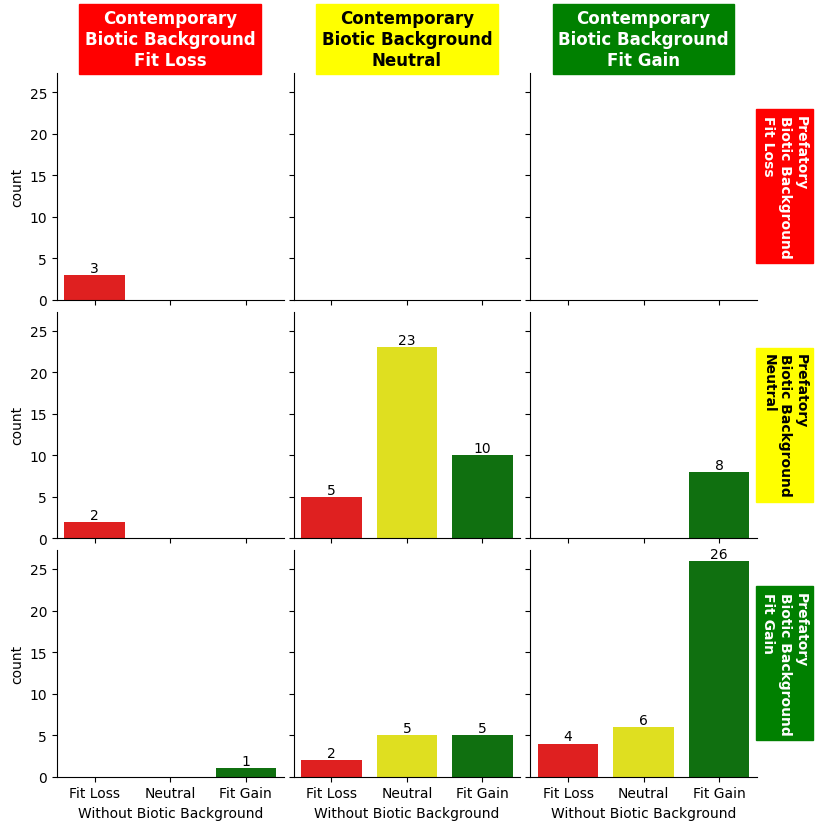

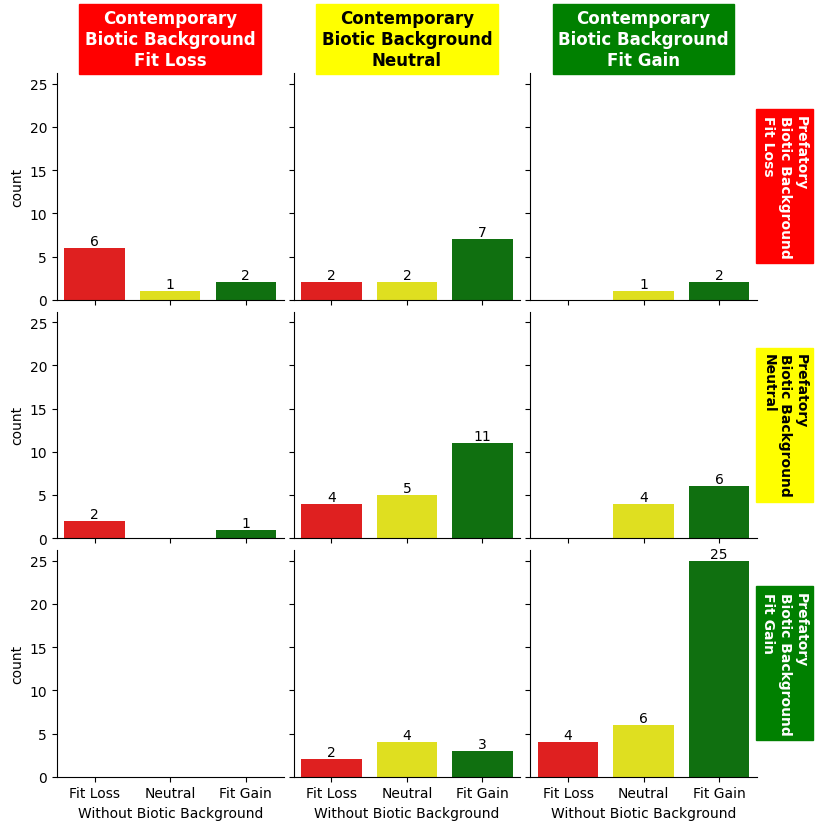

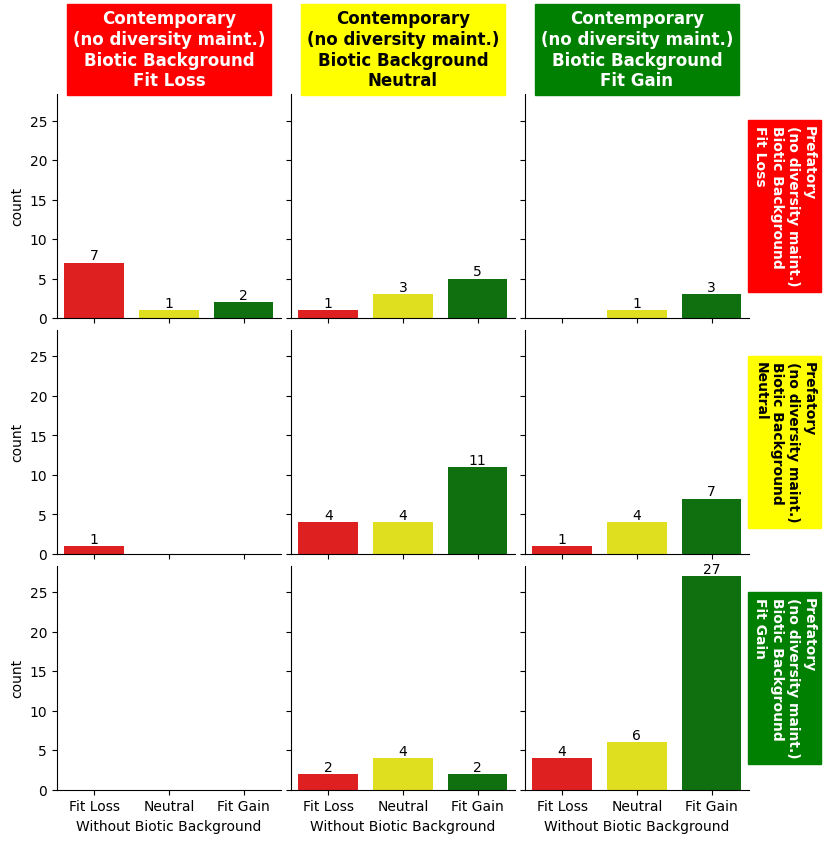

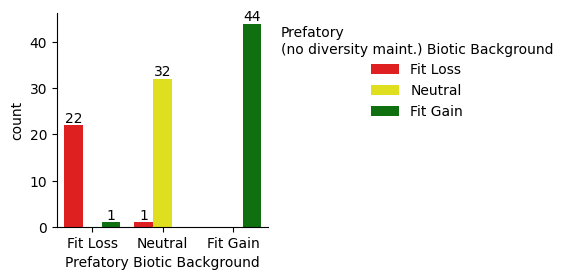

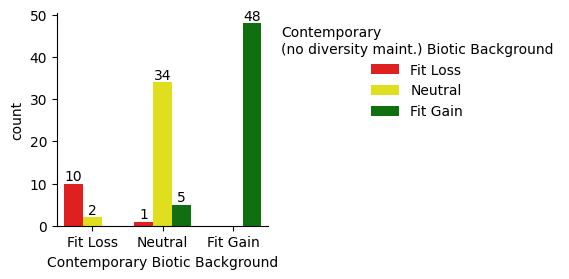

In [23]:
win_df = df[
    (df["Root ID"] == 1) 
    & (df["Competition Stint"] > 0)
].groupby(
    ["Biotic Background", "Competition Stint", "Assay Subject"]
)['Positive Fitness Differential Focal'].agg([len, sum]).reset_index()

win_df["Outcome"] = win_df.apply(
    lambda row: "Fit Loss" if row["sum"] < 3 else "Fit Gain" if row["sum"] > 17 else "Neutral",
    axis=1,
) 
assert set(win_df["len"]) == {20}

win_df["Biotic Background"] = win_df["Biotic Background"] + " Biotic Background" 

order = [
    "Fit Loss",
    "Neutral",
    "Fit Gain",
]
palette = [
    "red", 
    "yellow",
    "green",    
]

for subject, group in win_df.groupby("Assay Subject"):
    pivot_df = group.pivot("Competition Stint", "Biotic Background", "Outcome")
    tp.tee(
        barlabel_catplot,
        data=pivot_df,
        col="Contemporary Biotic Background",
        row="Prefatory Biotic Background",
        x="Without Biotic Background",
        kind="count",
        margin_titles=True,
        row_order=order,
        col_order=order,
        hue_order=order,
        palette=palette,
        teeplot_outattrs={
            "assay-subject" : subject,
        },
    )
            
    try:
        tp.tee(
            barlabel_catplot,
            data=pivot_df,
            col="Contemporary\n(no diversity maint.) Biotic Background",
            row="Prefatory\n(no diversity maint.) Biotic Background",
            x="Without Biotic Background",
            kind="count",
            margin_titles=True,
            row_order=order,
            col_order=order,
            hue_order=order,
            palette=palette,
            teeplot_outattrs={
                "assay-subject" : subject,
            },
        )

        tp.tee(
            barlabel_catplot,
            data=pivot_df,
            hue="Prefatory\n(no diversity maint.) Biotic Background",
            x="Prefatory Biotic Background",
            kind="count",
            margin_titles=True,
            order=order,
            hue_order=order,
            palette=palette,
            teeplot_outattrs={
                "assay-subject" : subject,
            },
        )

        tp.tee(
            barlabel_catplot,
            data=pivot_df,
            hue="Contemporary\n(no diversity maint.) Biotic Background",
            x="Contemporary Biotic Background",
            kind="count",
            margin_titles=True,
            order=order,
            hue_order=order,
            palette=palette,
            teeplot_outattrs={
                "assay-subject" : subject,
            },
        )

    except (ValueError, KeyError):
        pass
